In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
import random
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL one class",
    name= "centralized training_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.01,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

transfer_i = random.randint(0, 3)
configuration  = dict(wandb.config)


def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.5):
    trainloader = []
    valloader = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        print(data.size())
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        print(data_resampled.shape)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        train_size = int(train_ratio * len(dataset))
        test_size = len(dataset) - train_size
        val_size = int(val_ratio * test_size)
        test_size = test_size - val_size

        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        print(f"client {i}")
        print(f"train size = {train_size}")
        print(f"validation size = {val_size}")
        print(f"test set = {test_size}")
        if i == transfer_i:
            trainloader_transfer = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            valloader_transfer = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        else:
            trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
            valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))
            
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    
    # Create a DataLoader for the combined test data
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader, trainloader_transfer, valloader_transfer

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [3]:
# Define the CNN architecture
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs, name):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        wandb.log({f'{name} training accuraccy': train_acc,
                  f'{name} validation accuracy': test_acc})
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 49.54379653930664 Testing accuracy: 50.36496353149414.

Epoch 2/100
Epoch 2: Training accuracy: 49.63503646850586 Testing accuracy: 50.36496353149414.

Epoch 3/100
Epoch 3: Training accuracy: 52.37226104736328 Testing accuracy: 56.93430709838867.

Epoch 4/100
Epoch 4: Training accuracy: 66.1496353149414 Testing accuracy: 67.88320922851562.

Epoch 5/100
Epoch 5: Training accuracy: 77.09854125976562 Testing accuracy: 67.88320922851562.

Epoch 6/100
Epoch 6: Training accuracy: 70.25547790527344 Testing accuracy: 67.88320922851562.

Epoch 7/100
Epoch 7: Training accuracy: 79.83576965332031 Testing accuracy: 72.9926986694336.

Epoch 8/100
Epoch 8: Training accuracy: 81.47810363769531 Testing accuracy: 78.83211517333984.

Epoch 9/100
Epoch 9: Training accuracy: 83.0291976928711 Testing accuracy: 77.37226104736328.

Epoch 10/100
Epoch 10: Training accuracy: 84.30657196044922 Testing accuracy: 75.91240692138672.

Epoch 11/100
Epoch 11: Training accuracy

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


centralized training accuraccy,▁▁▄▆▆▆▇▇▇▇▇▇████████████████████████████
centralized validation accuracy,▁▂▄▆▆▆▇▇▇▇▇▇██▇█▇▇█▇▇█▇█▇█▆█▇▇▇▇█████▇█▇
centralized training accuraccy,97.62774
centralized validation accuracy,84.67153


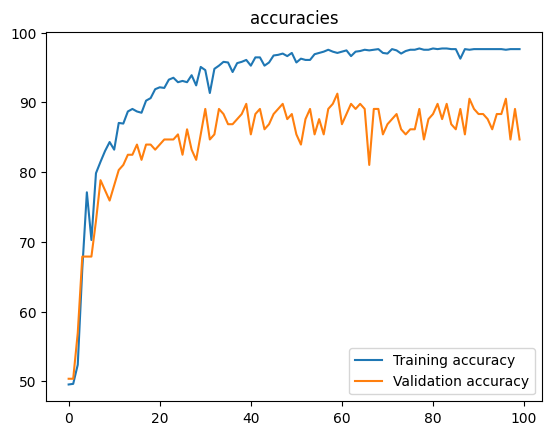

In [6]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'], name='centralized')
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

In [7]:
torch.save(net.state_dict(), 'NASA.pth')

## Federated Learning

In [8]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader, azure_train_loaders_transfer, azure_val_loaders_transfer = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

torch.Size([1002, 4, 50])
(1670, 4, 50)
client 0
train size = 1336
validation size = 167
test set = 167
torch.Size([936, 4, 50])
(1560, 4, 50)
client 1
train size = 1248
validation size = 156
test set = 156
torch.Size([1242, 4, 50])
(2070, 4, 50)
client 2
train size = 1656
validation size = 207
test set = 207
torch.Size([1014, 4, 50])
(1690, 4, 50)
client 3
train size = 1352
validation size = 169
test set = 169


In [9]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL one class",
    name= "federated learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config= configuration
)

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [10]:
# Define the CNN architecture
class Neural_Network_FL(nn.Module):
    def __init__(self):
        super(Neural_Network_FL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [11]:
def train_FL(model, train_loaders,test_loader, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()


In [12]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FL, parameters_centralized)
step = 0

In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_FL(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FL, trainloader, valloader, configuration).to_client()


In [14]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config):
    testloader = azure_test_loader
    set_parameters(net_FL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-08-19 00:11:24,224	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 49811662848.0, 'accelerator_type:G': 1.0, 'GPU': 2.0, 'node:192.168.1.146': 1.0, 'memory': 106227213312.0, 'CPU': 32.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.07022364031184804 / accuracy 48.49785232543945
(ClientAppActor pid=1242551) 
(ClientAppActor pid=1242551) Epoch 1/100
(ClientAppActor pid=1242551) Epoch 1: Training accuracy: 50.59880065917969 Testing accuracy: 47.90419006347656.
(ClientAppActor pid=1242551) Epoch 2: Training accuracy: 49.40119934082031 Testing accuracy: 52.09580993652344.
(ClientAppActor pid=1242551)  [repeated 12x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1242551) Epoch 8/100 [repeated 12x across cluster]
(ClientAppActor pid=1242552) Epoch 6: Training accuracy: 51.28205108642578 Testing accuracy: 44.230770111083984. [repeated 13x across cluster]
(ClientAppActor pid=1242552)  [repeated 15x across cluster]
(ClientAppActor pid=1242552) Epoch 12/100 [repeated 15x across cluster]
(ClientAppActor pid=1242551

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.06291168928146362, {'accuracy': tensor(48.4979, device='cuda:0')}, 71.97469461298897)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=1242552) Epoch 100: Training accuracy: 65.86538696289062 Testing accuracy: 71.79486846923828. [repeated 6x across cluster]
Server-side evaluation loss 0.06291168928146362 / accuracy 48.49785232543945


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 11/100 [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 18: Training accuracy: 68.34935760498047 Testing accuracy: 75.64102935791016. [repeated 23x across cluster]
(ClientAppActor pid=1242551)  [repeated 28x across cluster]
(ClientAppActor pid=1242551) Epoch 33/100 [repeated 28x across cluster]
(ClientAppActor pid=1242551) Epoch 40: Training accuracy: 70.67308044433594 Testing accuracy: 77.56410217285156. [repeated 28x across cluster]
(ClientAppActor pid=1242551)  [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 54/100 [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 91: Training accuracy: 73.15705108642578 Testing accuracy: 73.07691955566406. [repeated 58x across cluster]
(ClientAppActor pid=1242551)  [repeated 106x across cluster]
(ClientAppActor pid=1242551) Epoch 51/100 [repeated 106x across cluster]
(ClientAppActor pid=1242551) Epoch 84: Tr

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.05747946825894443, {'accuracy': tensor(66.3805, device='cuda:0')}, 121.84040839898807)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05747946825894443 / accuracy 66.38054656982422


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 6x across cluster]
(ClientAppActor pid=1242551) Epoch 1/100 [repeated 6x across cluster]
(ClientAppActor pid=1242551) Epoch 1: Training accuracy: 70.5128173828125 Testing accuracy: 75.0. [repeated 6x across cluster]
(ClientAppActor pid=1242551)  [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 11/100 [repeated 17x across cluster]
(ClientAppActor pid=1242552) Epoch 7: Training accuracy: 67.06586456298828 Testing accuracy: 66.4670639038086. [repeated 16x across cluster]
(ClientAppActor pid=1242552)  [repeated 15x across cluster]
(ClientAppActor pid=1242552) Epoch 14/100 [repeated 15x across cluster]
(ClientAppActor pid=1242551) Epoch 20: Training accuracy: 69.31089782714844 Testing accuracy: 71.79486846923828. [repeated 16x across cluster]
(ClientAppActor pid=1242551)  [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 29/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 20: Training accuracy: 69.311

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.05793445760553533, {'accuracy': tensor(67.0958, device='cuda:0')}, 208.9309902399982)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05793445760553533 / accuracy 67.0958480834961
(ClientAppActor pid=1242551)  [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 7/100 [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 13: Training accuracy: 70.73353576660156 Testing accuracy: 70.05988311767578. [repeated 25x across cluster]
(ClientAppActor pid=1242551)  [repeated 56x across cluster]
(ClientAppActor pid=1242551) Epoch 55/100 [repeated 56x across cluster]
(ClientAppActor pid=1242551) Epoch 100: Training accuracy: 72.60478973388672 Testing accuracy: 68.26347351074219. [repeated 94x across cluster]
(ClientAppActor pid=1242552)  [repeated 158x across cluster]
(ClientAppActor pid=1242552) Epoch 24/100 [repeated 158x across cluster]
(ClientAppActor pid=1242552) Epoch 54: Training accuracy: 72.78106689453125 Testing accuracy: 68.0473403930664. [repeated 142x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.055276979099620475, {'accuracy': tensor(67.6681, device='cuda:0')}, 224.58658998299506)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.055276979099620475 / accuracy 67.66809844970703
(ClientAppActor pid=1242552)  [repeated 102x across cluster]
(ClientAppActor pid=1242552) Epoch 20/100 [repeated 102x across cluster]
(ClientAppActor pid=1242551) Epoch 11: Training accuracy: 65.68047332763672 Testing accuracy: 60.946746826171875. [repeated 81x across cluster]
(ClientAppActor pid=1242551)  [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 21/100 [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 23: Training accuracy: 70.63609313964844 Testing accuracy: 66.86390686035156. [repeated 20x across cluster]
(ClientAppActor pid=1242552)  [repeated 13x across cluster]
(ClientAppActor pid=1242552) Epoch 37/100 [repeated 13x across cluster]
(ClientAppActor pid=1242552) Epoch 40: Training accuracy: 71.556884765625 Testing accuracy: 67.06586456298828. [repeated 17x across cluster]
(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 4

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 0.05437457019632513, {'accuracy': tensor(67.9542, device='cuda:0')}, 291.52515728300205)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05437457019632513 / accuracy 67.9542236328125
(ClientAppActor pid=1242551)  [repeated 91x across cluster]
(ClientAppActor pid=1242551) Epoch 29/100 [repeated 91x across cluster]
(ClientAppActor pid=1242551) Epoch 75: Training accuracy: 71.1077880859375 Testing accuracy: 65.8682632446289. [repeated 95x across cluster]
(ClientAppActor pid=1242551)  [repeated 95x across cluster]
(ClientAppActor pid=1242551) Epoch 14/100 [repeated 95x across cluster]
(ClientAppActor pid=1242551) Epoch 42: Training accuracy: 72.11538696289062 Testing accuracy: 65.68047332763672. [repeated 76x across cluster]
(ClientAppActor pid=1242551)  [repeated 50x across cluster]
(ClientAppActor pid=1242551) Epoch 57/100 [repeated 50x across cluster]
(ClientAppActor pid=1242551) Epoch 63: Training accuracy: 77.14497375488281 Testing accuracy: 69.23076629638672. [repeated 27x across cluster]
(ClientAppActor pid=1242551)  [repeated 28x across cluster]
(ClientAppActor pid=1242551) Epoch 79/100

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (6, 0.05401570688594471, {'accuracy': tensor(67.3820, device='cuda:0')}, 345.001847994994)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05401570688594471 / accuracy 67.38197326660156
(ClientAppActor pid=1242551)  [repeated 106x across cluster]
(ClientAppActor pid=1242551) Epoch 28/100 [repeated 106x across cluster]
(ClientAppActor pid=1242551) Epoch 35: Training accuracy: 74.25149536132812 Testing accuracy: 70.65868377685547. [repeated 134x across cluster]
(ClientAppActor pid=1242551)  [repeated 110x across cluster]
(ClientAppActor pid=1242551) Epoch 66/100 [repeated 110x across cluster]
(ClientAppActor pid=1242551) Epoch 68: Training accuracy: 78.59281158447266 Testing accuracy: 71.25748443603516. [repeated 84x across cluster]
(ClientAppActor pid=1242551)  [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 82/100 [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 84: Training accuracy: 78.29341125488281 Testing accuracy: 72.45509338378906. [repeated 27x across cluster]
(ClientAppActor pid=1242551)  [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoc

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (7, 0.054223244840448555, {'accuracy': tensor(68.9557, device='cuda:0')}, 398.2140105180006)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.054223244840448555 / accuracy 68.95565032958984


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 7x across cluster]
(ClientAppActor pid=1242551) Epoch 3/100 [repeated 7x across cluster]
(ClientAppActor pid=1242551) Epoch 3: Training accuracy: 72.45509338378906 Testing accuracy: 68.26347351074219. [repeated 7x across cluster]
(ClientAppActor pid=1242551)  [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 12/100 [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 12: Training accuracy: 74.85029602050781 Testing accuracy: 70.65868377685547. [repeated 17x across cluster]
(ClientAppActor pid=1242551)  [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 23/100 [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 23: Training accuracy: 76.49700927734375 Testing accuracy: 70.05988311767578. [repeated 17x across cluster]
(ClientAppActor pid=1242551)  [repeated 23x across cluster]
(ClientAppActor pid=1242551) Epoch 37/100 [repeated 23x across cluster]
(ClientAppActor pid=1242551) Epoch 37: Training 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (8, 0.05367442152716897, {'accuracy': tensor(68.8126, device='cuda:0')}, 462.87532931999885)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05367442152716897 / accuracy 68.81259155273438
(ClientAppActor pid=1242551) Epoch 100: Training accuracy: 80.47337341308594 Testing accuracy: 68.63905334472656. [repeated 8x across cluster]
(ClientAppActor pid=1242551)  [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 11/100 [repeated 17x across cluster]
(ClientAppActor pid=1242552) Epoch 7: Training accuracy: 77.08333587646484 Testing accuracy: 76.92308044433594. [repeated 18x across cluster]
(ClientAppActor pid=1242551)  [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 24/100 [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 24: Training accuracy: 77.02095794677734 Testing accuracy: 68.26347351074219. [repeated 19x across cluster]
(ClientAppActor pid=1242551)  [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 37/100 [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 37: Training accuracy: 78.14371490478516 Testing accuracy: 70.65

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (9, 0.052951157093048096, {'accuracy': tensor(69.2418, device='cuda:0')}, 528.7246704569989)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.052951157093048096 / accuracy 69.24177551269531


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 13x across cluster]
(ClientAppActor pid=1242551) Epoch 5/100 [repeated 13x across cluster]
(ClientAppActor pid=1242551) Epoch 4: Training accuracy: 72.97904205322266 Testing accuracy: 63.473052978515625. [repeated 12x across cluster]
(ClientAppActor pid=1242551)  [repeated 30x across cluster]
(ClientAppActor pid=1242551) Epoch 28/100 [repeated 30x across cluster]
(ClientAppActor pid=1242551) Epoch 27: Training accuracy: 77.84431457519531 Testing accuracy: 70.65868377685547. [repeated 30x across cluster]
(ClientAppActor pid=1242551)  [repeated 37x across cluster]
(ClientAppActor pid=1242551) Epoch 52/100 [repeated 37x across cluster]
(ClientAppActor pid=1242551) Epoch 51: Training accuracy: 78.8922119140625 Testing accuracy: 73.05389404296875. [repeated 37x across cluster]
(ClientAppActor pid=1242551)  [repeated 35x across cluster]
(ClientAppActor pid=1242551) Epoch 73/100 [repeated 35x across cluster]
(ClientAppActor pid=1242551) Epoch 72: Traini

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (10, 0.05247203328392722, {'accuracy': tensor(69.3848, device='cuda:0')}, 594.4548949759919)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05247203328392722 / accuracy 69.38483428955078


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 11x across cluster]
(ClientAppActor pid=1242551) Epoch 6/100 [repeated 11x across cluster]
(ClientAppActor pid=1242551) Epoch 5: Training accuracy: 75.14970397949219 Testing accuracy: 72.45509338378906. [repeated 10x across cluster]
(ClientAppActor pid=1242551)  [repeated 15x across cluster]
(ClientAppActor pid=1242551) Epoch 15/100 [repeated 15x across cluster]
(ClientAppActor pid=1242551) Epoch 14: Training accuracy: 75.67365264892578 Testing accuracy: 66.4670639038086. [repeated 15x across cluster]
(ClientAppActor pid=1242551)  [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 25/100 [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 24: Training accuracy: 77.84431457519531 Testing accuracy: 72.45509338378906. [repeated 16x across cluster]
(ClientAppActor pid=1242552)  [repeated 14x across cluster]
(ClientAppActor pid=1242552) Epoch 24/100 [repeated 14x across cluster]
(ClientAppActor pid=1242552) Epoch 23: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (11, 0.054149844429709694, {'accuracy': tensor(69.8140, device='cuda:0')}, 654.7559215309884)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.054149844429709694 / accuracy 69.81401824951172
(ClientAppActor pid=1242551)  [repeated 22x across cluster]
(ClientAppActor pid=1242551) Epoch 1/100 [repeated 22x across cluster]
(ClientAppActor pid=1242551) Epoch 100: Training accuracy: 84.29486846923828 Testing accuracy: 78.20513153076172. [repeated 23x across cluster]
(ClientAppActor pid=1242552)  [repeated 23x across cluster]
(ClientAppActor pid=1242552) Epoch 11/100 [repeated 23x across cluster]
(ClientAppActor pid=1242552) Epoch 10: Training accuracy: 76.7964096069336 Testing accuracy: 73.65269470214844. [repeated 22x across cluster]
(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 18/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 17: Training accuracy: 77.39521026611328 Testing accuracy: 67.6646728515625. [repeated 16x across cluster]
(ClientAppActor pid=1242551)  [repeated 15x across cluster]
(ClientAppActor pid=1242551) Epoch 31/1

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (12, 0.05300327864560214, {'accuracy': tensor(69.5279, device='cuda:0')}, 751.9811937049963)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05300327864560214 / accuracy 69.52790069580078
(ClientAppActor pid=1242552)  [repeated 19x across cluster]
(ClientAppActor pid=1242552) Epoch 8/100 [repeated 19x across cluster]
(ClientAppActor pid=1242552) Epoch 7: Training accuracy: 80.12820434570312 Testing accuracy: 75.64102935791016. [repeated 18x across cluster]
(ClientAppActor pid=1242552)  [repeated 23x across cluster]
(ClientAppActor pid=1242552) Epoch 19/100 [repeated 23x across cluster]
(ClientAppActor pid=1242552) Epoch 18: Training accuracy: 81.49038696289062 Testing accuracy: 74.35897064208984. [repeated 23x across cluster]
(ClientAppActor pid=1242551)  [repeated 87x across cluster]
(ClientAppActor pid=1242551) Epoch 78/100 [repeated 87x across cluster]
(ClientAppActor pid=1242551) Epoch 77: Training accuracy: 80.69526672363281 Testing accuracy: 71.00592041015625. [repeated 87x across cluster]
(ClientAppActor pid=1242551)  [repeated 146x across cluster]
(ClientAppActor pid=1242551) Epoch 71/1

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1242551)  [repeated 8x across cluster]
(ClientAppActor pid=1242551) Epoch 100/100 [repeated 8x across cluster]
(ClientAppActor pid=1242551) Epoch 100: Training accuracy: 79.94011688232422 Testing accuracy: 72.45509338378906. [repeated 9x across cluster]


INFO :      fit progress: (13, 0.05440027605403553, {'accuracy': tensor(70.1001, device='cuda:0')}, 781.0183910429914)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05440027605403553 / accuracy 70.10014343261719


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 10/100 [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 9: Training accuracy: 77.61975860595703 Testing accuracy: 68.86227416992188. [repeated 14x across cluster]
(ClientAppActor pid=1242551)  [repeated 14x across cluster]
(ClientAppActor pid=1242551) Epoch 18/100 [repeated 14x across cluster]
(ClientAppActor pid=1242551) Epoch 17: Training accuracy: 76.57185363769531 Testing accuracy: 71.25748443603516. [repeated 14x across cluster]
(ClientAppActor pid=1242551)  [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 27/100 [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 26: Training accuracy: 78.81736755371094 Testing accuracy: 70.65868377685547. [repeated 16x across cluster]
(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 26/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 25: Train

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (14, 0.053941309452056885, {'accuracy': tensor(70.3863, device='cuda:0')}, 856.7075049099949)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.053941309452056885 / accuracy 70.38626861572266


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 11x across cluster]
(ClientAppActor pid=1242551) Epoch 6/100 [repeated 11x across cluster]
(ClientAppActor pid=1242551) Epoch 5: Training accuracy: 78.18047332763672 Testing accuracy: 69.8224868774414. [repeated 10x across cluster]
(ClientAppActor pid=1242552)  [repeated 29x across cluster]
(ClientAppActor pid=1242552) Epoch 12/100 [repeated 29x across cluster]
(ClientAppActor pid=1242552) Epoch 11: Training accuracy: 77.69461059570312 Testing accuracy: 68.26347351074219. [repeated 29x across cluster]
(ClientAppActor pid=1242552)  [repeated 29x across cluster]
(ClientAppActor pid=1242552) Epoch 21/100 [repeated 29x across cluster]
(ClientAppActor pid=1242552) Epoch 20: Training accuracy: 79.41616821289062 Testing accuracy: 72.45509338378906. [repeated 29x across cluster]
(ClientAppActor pid=1242551)  [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 65/100 [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 64: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (15, 0.051986401731317695, {'accuracy': tensor(70.1001, device='cuda:0')}, 895.2734782629996)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242552)  [repeated 65x across cluster]
(ClientAppActor pid=1242552) Epoch 100/100 [repeated 65x across cluster]
(ClientAppActor pid=1242552) Epoch 99: Training accuracy: 80.0898208618164 Testing accuracy: 74.85029602050781. [repeated 66x across cluster]
Server-side evaluation loss 0.051986401731317695 / accuracy 70.10014343261719
(ClientAppActor pid=1242551)  [repeated 56x across cluster]
(ClientAppActor pid=1242551) Epoch 42/100 [repeated 56x across cluster]
(ClientAppActor pid=1242551) Epoch 41: Training accuracy: 81.58283996582031 Testing accuracy: 71.00592041015625. [repeated 55x across cluster]
(ClientAppActor pid=1242551)  [repeated 36x across cluster]
(ClientAppActor pid=1242551) Epoch 64/100 [repeated 36x across cluster]
(ClientAppActor pid=1242551) Epoch 63: Training accuracy: 81.28697967529297 Testing accuracy: 71.5976333618164. [repeated 36x across cluster]
(ClientAppActor pid=1242551)  [repeated 36x across cluster]
(ClientAppActor pid=1242551) Epoch 87/

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (16, 0.052389004013755104, {'accuracy': tensor(69.9571, device='cuda:0')}, 961.7428475929919)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.052389004013755104 / accuracy 69.95708465576172
(ClientAppActor pid=1242551)  [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 4/100 [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 3: Training accuracy: 76.47928619384766 Testing accuracy: 71.00592041015625. [repeated 18x across cluster]
(ClientAppActor pid=1242551)  [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 13/100 [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 12: Training accuracy: 79.80769348144531 Testing accuracy: 70.41419982910156. [repeated 19x across cluster]
(ClientAppActor pid=1242552)  [repeated 23x across cluster]
(ClientAppActor pid=1242552) Epoch 28/100 [repeated 23x across cluster]
(ClientAppActor pid=1242552) Epoch 27: Training accuracy: 84.29486846923828 Testing accuracy: 80.12820434570312. [repeated 23x across cluster]
(ClientAppActor pid=1242552)  [repeated 22x across cluster]
(ClientAppActor pid=1242552) Epoch 41/1

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (17, 0.05416814847425981, {'accuracy': tensor(69.2418, device='cuda:0')}, 1059.983143311998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05416814847425981 / accuracy 69.24177551269531


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 4/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 3: Training accuracy: 76.57185363769531 Testing accuracy: 67.06586456298828. [repeated 15x across cluster]
(ClientAppActor pid=1242552)  [repeated 19x across cluster]
(ClientAppActor pid=1242552) Epoch 11/100 [repeated 19x across cluster]
(ClientAppActor pid=1242552) Epoch 10: Training accuracy: 79.49102020263672 Testing accuracy: 73.05389404296875. [repeated 19x across cluster]
(ClientAppActor pid=1242551)  [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 36/100 [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 35: Training accuracy: 85.09615325927734 Testing accuracy: 77.56410217285156. [repeated 19x across cluster]
(ClientAppActor pid=1242551)  [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 57/100 [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 56: Traini

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (18, 0.05274857716126875, {'accuracy': tensor(70.9585, device='cuda:0')}, 1125.2485354809905)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05274857716126875 / accuracy 70.95851135253906
(ClientAppActor pid=1242551)  [repeated 11x across cluster]
(ClientAppActor pid=1242551) Epoch 1/100 [repeated 11x across cluster]
(ClientAppActor pid=1242552) Epoch 100: Training accuracy: 78.9670639038086 Testing accuracy: 72.45509338378906. [repeated 11x across cluster]
(ClientAppActor pid=1242551)  [repeated 31x across cluster]
(ClientAppActor pid=1242551) Epoch 21/100 [repeated 31x across cluster]
(ClientAppActor pid=1242551) Epoch 20: Training accuracy: 81.21302032470703 Testing accuracy: 72.18934631347656. [repeated 30x across cluster]
(ClientAppActor pid=1242551)  [repeated 96x across cluster]
(ClientAppActor pid=1242551) Epoch 4/100 [repeated 96x across cluster]
(ClientAppActor pid=1242551) Epoch 3: Training accuracy: 80.28845977783203 Testing accuracy: 73.07691955566406. [repeated 96x across cluster]
(ClientAppActor pid=1242551)  [repeated 164x across cluster]
(ClientAppActor pid=1242551) Epoch 92/10

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (19, 0.05412959510629827, {'accuracy': tensor(69.9571, device='cuda:0')}, 1143.86751543)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05412959510629827 / accuracy 69.95708465576172
(ClientAppActor pid=1242551)  [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 7/100 [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 6: Training accuracy: 79.34131622314453 Testing accuracy: 71.25748443603516. [repeated 18x across cluster]
(ClientAppActor pid=1242551)  [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 23/100 [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 22: Training accuracy: 80.0898208618164 Testing accuracy: 73.05389404296875. [repeated 27x across cluster]
(ClientAppActor pid=1242552)  [repeated 14x across cluster]
(ClientAppActor pid=1242552) Epoch 22/100 [repeated 14x across cluster]
(ClientAppActor pid=1242552) Epoch 21: Training accuracy: 84.69551086425781 Testing accuracy: 78.20513153076172. [repeated 14x across cluster]
(ClientAppActor pid=1242552)  [repeated 18x across cluster]
(ClientAppActor pid=1242552) Epoch 30/100

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (20, 0.05330281907861883, {'accuracy': tensor(70.2432, device='cuda:0')}, 1217.29341456799)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05330281907861883 / accuracy 70.24320220947266


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 88x across cluster]
(ClientAppActor pid=1242551) Epoch 38/100 [repeated 88x across cluster]
(ClientAppActor pid=1242551) Epoch 37: Training accuracy: 84.29486846923828 Testing accuracy: 75.64102935791016. [repeated 88x across cluster]
(ClientAppActor pid=1242551)  [repeated 105x across cluster]
(ClientAppActor pid=1242551) Epoch 33/100 [repeated 105x across cluster]
(ClientAppActor pid=1242551) Epoch 32: Training accuracy: 79.95561981201172 Testing accuracy: 69.8224868774414. [repeated 105x across cluster]
(ClientAppActor pid=1242552)  [repeated 83x across cluster]
(ClientAppActor pid=1242552) Epoch 28/100 [repeated 83x across cluster]
(ClientAppActor pid=1242552) Epoch 27: Training accuracy: 80.46407318115234 Testing accuracy: 75.44910430908203. [repeated 84x across cluster]
(ClientAppActor pid=1242552)  [repeated 8x across cluster]
(ClientAppActor pid=1242552) Epoch 36/100 [repeated 8x across cluster]
(ClientAppActor pid=1242552) Epoch 35: Trai

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (21, 0.05415578321977095, {'accuracy': tensor(69.3848, device='cuda:0')}, 1259.2449150869943)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05415578321977095 / accuracy 69.38483428955078


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 7x across cluster]
(ClientAppActor pid=1242551) Epoch 1/100 [repeated 7x across cluster]
(ClientAppActor pid=1242552) Epoch 100: Training accuracy: 81.51197814941406 Testing accuracy: 77.2455062866211. [repeated 7x across cluster]
(ClientAppActor pid=1242551)  [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 10/100 [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 9: Training accuracy: 75.74850463867188 Testing accuracy: 71.25748443603516. [repeated 16x across cluster]
(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 15/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 14: Training accuracy: 80.76923370361328 Testing accuracy: 75.0. [repeated 16x across cluster]
(ClientAppActor pid=1242551)  [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 30/100 [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 29: Training accuracy: 78.

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (22, 0.053253011270002884, {'accuracy': tensor(70.3863, device='cuda:0')}, 1352.0347588379955)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.053253011270002884 / accuracy 70.38626861572266
(ClientAppActor pid=1242551)  [repeated 41x across cluster]
(ClientAppActor pid=1242551) Epoch 7/100 [repeated 41x across cluster]
(ClientAppActor pid=1242551) Epoch 6: Training accuracy: 82.7724380493164 Testing accuracy: 75.64102935791016. [repeated 40x across cluster]
(ClientAppActor pid=1242552)  [repeated 63x across cluster]
(ClientAppActor pid=1242552) Epoch 44/100 [repeated 63x across cluster]
(ClientAppActor pid=1242552) Epoch 43: Training accuracy: 81.36227416992188 Testing accuracy: 77.2455062866211. [repeated 63x across cluster]
(ClientAppActor pid=1242551)  [repeated 56x across cluster]
(ClientAppActor pid=1242551) Epoch 57/100 [repeated 56x across cluster]
(ClientAppActor pid=1242551) Epoch 56: Training accuracy: 85.09615325927734 Testing accuracy: 78.84615325927734. [repeated 56x across cluster]
(ClientAppActor pid=1242551)  [repeated 37x across cluster]
(ClientAppActor pid=1242551) Epoch 76/100

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (23, 0.05257383801720359, {'accuracy': tensor(70.1001, device='cuda:0')}, 1446.4986148019962)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05257383801720359 / accuracy 70.10014343261719


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 4/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 3: Training accuracy: 82.6121826171875 Testing accuracy: 75.0. [repeated 15x across cluster]
(ClientAppActor pid=1242552)  [repeated 26x across cluster]
(ClientAppActor pid=1242552) Epoch 10/100 [repeated 26x across cluster]
(ClientAppActor pid=1242552) Epoch 9: Training accuracy: 84.85576629638672 Testing accuracy: 76.28205108642578. [repeated 26x across cluster]
(ClientAppActor pid=1242551)  [repeated 31x across cluster]
(ClientAppActor pid=1242551) Epoch 54/100 [repeated 31x across cluster]
(ClientAppActor pid=1242551) Epoch 53: Training accuracy: 81.73652648925781 Testing accuracy: 77.2455062866211. [repeated 31x across cluster]
(ClientAppActor pid=1242551)  [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 75/100 [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 74: Training accuracy: 80.

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (24, 0.054000388492237435, {'accuracy': tensor(69.5279, device='cuda:0')}, 1505.9108126329957)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.054000388492237435 / accuracy 69.52790069580078


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242552)  [repeated 9x across cluster]
(ClientAppActor pid=1242552) Epoch 2/100 [repeated 9x across cluster]
(ClientAppActor pid=1242552) Epoch 1: Training accuracy: 80.36859130859375 Testing accuracy: 74.35897064208984. [repeated 8x across cluster]
(ClientAppActor pid=1242551)  [repeated 32x across cluster]
(ClientAppActor pid=1242551) Epoch 21/100 [repeated 32x across cluster]
(ClientAppActor pid=1242551) Epoch 20: Training accuracy: 81.80473327636719 Testing accuracy: 70.41419982910156. [repeated 32x across cluster]
(ClientAppActor pid=1242552)  [repeated 32x across cluster]
(ClientAppActor pid=1242552) Epoch 27/100 [repeated 32x across cluster]
(ClientAppActor pid=1242552) Epoch 26: Training accuracy: 85.09615325927734 Testing accuracy: 78.20513153076172. [repeated 32x across cluster]
(ClientAppActor pid=1242551)  [repeated 33x across cluster]
(ClientAppActor pid=1242551) Epoch 61/100 [repeated 33x across cluster]
(ClientAppActor pid=1242551) Epoch 60: Training 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (25, 0.05460675738074563, {'accuracy': tensor(69.5279, device='cuda:0')}, 1579.454205172995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05460675738074563 / accuracy 69.52790069580078
(ClientAppActor pid=1242551)  [repeated 7x across cluster]
(ClientAppActor pid=1242551) Epoch 1/100 [repeated 7x across cluster]
(ClientAppActor pid=1242551) Epoch 100: Training accuracy: 78.8922119140625 Testing accuracy: 73.05389404296875. [repeated 7x across cluster]
(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 8/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 7: Training accuracy: 84.93589782714844 Testing accuracy: 76.92308044433594. [repeated 15x across cluster]
(ClientAppActor pid=1242551)  [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 19/100 [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 18: Training accuracy: 80.61376953125 Testing accuracy: 73.05389404296875. [repeated 16x across cluster]
(ClientAppActor pid=1242551)  [repeated 15x across cluster]
(ClientAppActor pid=1242551) Epoch 27/100 [repe

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (26, 0.0526570894501426, {'accuracy': tensor(69.9571, device='cuda:0')}, 1636.0120938990003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0526570894501426 / accuracy 69.95708465576172
(ClientAppActor pid=1242551)  [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 2/100 [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 1: Training accuracy: 80.84935760498047 Testing accuracy: 72.43589782714844. [repeated 26x across cluster]
(ClientAppActor pid=1242551)  [repeated 39x across cluster]
(ClientAppActor pid=1242551) Epoch 22/100 [repeated 39x across cluster]
(ClientAppActor pid=1242551) Epoch 21: Training accuracy: 85.57691955566406 Testing accuracy: 75.64102935791016. [repeated 39x across cluster]
(ClientAppActor pid=1242551)  [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 32/100 [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 31: Training accuracy: 83.41345977783203 Testing accuracy: 75.0. [repeated 17x across cluster]
(ClientAppActor pid=1242551)  [repeated 14x across cluster]
(ClientAppActor pid=1242551) Epoch 40/100 [repeated 14

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (27, 0.05020384355024858, {'accuracy': tensor(71.2446, device='cuda:0')}, 1698.1537214679993)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05020384355024858 / accuracy 71.24463653564453


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 7x across cluster]
(ClientAppActor pid=1242551) Epoch 1/100 [repeated 7x across cluster]
(ClientAppActor pid=1242552) Epoch 100: Training accuracy: 80.38922119140625 Testing accuracy: 73.65269470214844. [repeated 8x across cluster]
(ClientAppActor pid=1242551)  [repeated 29x across cluster]
(ClientAppActor pid=1242551) Epoch 24/100 [repeated 29x across cluster]
(ClientAppActor pid=1242551) Epoch 23: Training accuracy: 80.31436920166016 Testing accuracy: 74.85029602050781. [repeated 28x across cluster]
(ClientAppActor pid=1242551)  [repeated 30x across cluster]
(ClientAppActor pid=1242551) Epoch 47/100 [repeated 30x across cluster]
(ClientAppActor pid=1242551) Epoch 46: Training accuracy: 80.98802185058594 Testing accuracy: 76.04790496826172. [repeated 30x across cluster]
(ClientAppActor pid=1242551)  [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 68/100 [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 67: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (28, 0.05101730606772683, {'accuracy': tensor(71.1016, device='cuda:0')}, 1767.0706950439926)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05101730606772683 / accuracy 71.10157012939453
(ClientAppActor pid=1242551)  [repeated 10x across cluster]
(ClientAppActor pid=1242551) Epoch 1/100 [repeated 10x across cluster]
(ClientAppActor pid=1242552) Epoch 100: Training accuracy: 82.76627349853516 Testing accuracy: 71.5976333618164. [repeated 10x across cluster]
(ClientAppActor pid=1242551)  [repeated 33x across cluster]
(ClientAppActor pid=1242551) Epoch 22/100 [repeated 33x across cluster]
(ClientAppActor pid=1242551) Epoch 21: Training accuracy: 81.88623046875 Testing accuracy: 77.2455062866211. [repeated 32x across cluster]
(ClientAppActor pid=1242551)  [repeated 38x across cluster]
(ClientAppActor pid=1242551) Epoch 45/100 [repeated 38x across cluster]
(ClientAppActor pid=1242551) Epoch 44: Training accuracy: 80.0898208618164 Testing accuracy: 77.2455062866211. [repeated 38x across cluster]
(ClientAppActor pid=1242552)  [repeated 74x across cluster]
(ClientAppActor pid=1242552) Epoch 66/100 [re

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (29, 0.05352159521796487, {'accuracy': tensor(69.8140, device='cuda:0')}, 1846.684275156993)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05352159521796487 / accuracy 69.81401824951172


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 8x across cluster]
(ClientAppActor pid=1242551) Epoch 1/100 [repeated 8x across cluster]
(ClientAppActor pid=1242551) Epoch 100: Training accuracy: 81.80473327636719 Testing accuracy: 70.41419982910156. [repeated 8x across cluster]
(ClientAppActor pid=1242551)  [repeated 15x across cluster]
(ClientAppActor pid=1242551) Epoch 9/100 [repeated 15x across cluster]
(ClientAppActor pid=1242551) Epoch 8: Training accuracy: 84.85576629638672 Testing accuracy: 76.92308044433594. [repeated 14x across cluster]
(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 14/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 13: Training accuracy: 81.21257781982422 Testing accuracy: 77.84431457519531. [repeated 16x across cluster]
(ClientAppActor pid=1242551)  [repeated 33x across cluster]
(ClientAppActor pid=1242551) Epoch 44/100 [repeated 33x across cluster]
(ClientAppActor pid=1242551) Epoch 43: Training 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1242552)  [repeated 6x across cluster]
(ClientAppActor pid=1242552) Epoch 100/100 [repeated 6x across cluster]
(ClientAppActor pid=1242552) Epoch 100: Training accuracy: 81.73652648925781 Testing accuracy: 77.84431457519531. [repeated 7x across cluster]


INFO :      fit progress: (30, 0.052272677421569824, {'accuracy': tensor(69.9571, device='cuda:0')}, 1889.3302802309918)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.052272677421569824 / accuracy 69.95708465576172


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242552)  [repeated 14x across cluster]
(ClientAppActor pid=1242552) Epoch 6/100 [repeated 14x across cluster]
(ClientAppActor pid=1242552) Epoch 5: Training accuracy: 85.01602935791016 Testing accuracy: 76.92308044433594. [repeated 12x across cluster]
(ClientAppActor pid=1242552)  [repeated 15x across cluster]
(ClientAppActor pid=1242552) Epoch 13/100 [repeated 15x across cluster]
(ClientAppActor pid=1242552) Epoch 12: Training accuracy: 83.41345977783203 Testing accuracy: 76.92308044433594. [repeated 15x across cluster]
(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 20/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 19: Training accuracy: 84.93589782714844 Testing accuracy: 78.20513153076172. [repeated 16x across cluster]
(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 27/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 26: Traini

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (31, 0.05141448974609375, {'accuracy': tensor(70.2432, device='cuda:0')}, 1976.7968270080019)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05141448974609375 / accuracy 70.24320220947266
(ClientAppActor pid=1242551)  [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 3/100 [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 2: Training accuracy: 81.97115325927734 Testing accuracy: 75.64102935791016. [repeated 19x across cluster]
(ClientAppActor pid=1242551)  [repeated 34x across cluster]
(ClientAppActor pid=1242551) Epoch 24/100 [repeated 34x across cluster]
(ClientAppActor pid=1242551) Epoch 23: Training accuracy: 84.85576629638672 Testing accuracy: 77.56410217285156. [repeated 34x across cluster]
(ClientAppActor pid=1242552)  [repeated 33x across cluster]
(ClientAppActor pid=1242552) Epoch 33/100 [repeated 33x across cluster]
(ClientAppActor pid=1242552) Epoch 32: Training accuracy: 83.35798645019531 Testing accuracy: 73.3727798461914. [repeated 33x across cluster]
(ClientAppActor pid=1242551)  [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 48/100

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (32, 0.051577427170493385, {'accuracy': tensor(70.8155, device='cuda:0')}, 2057.0917409589892)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.051577427170493385 / accuracy 70.8154525756836


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 15/100 [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 14: Training accuracy: 86.05769348144531 Testing accuracy: 77.56410217285156. [repeated 19x across cluster]
(ClientAppActor pid=1242551)  [repeated 29x across cluster]
(ClientAppActor pid=1242551) Epoch 37/100 [repeated 29x across cluster]
(ClientAppActor pid=1242551) Epoch 36: Training accuracy: 85.81730651855469 Testing accuracy: 76.28205108642578. [repeated 29x across cluster]
(ClientAppActor pid=1242551)  [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 58/100 [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 57: Training accuracy: 86.05769348144531 Testing accuracy: 77.56410217285156. [repeated 26x across cluster]
(ClientAppActor pid=1242551)  [repeated 83x across cluster]
(ClientAppActor pid=1242551) Epoch 33/100 [repeated 83x across cluster]
(ClientAppActor pid=1242551) Epoch 32: Trai

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (33, 0.05053623156114058, {'accuracy': tensor(71.2446, device='cuda:0')}, 2122.556202926993)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05053623156114058 / accuracy 71.24463653564453


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242552)  [repeated 10x across cluster]
(ClientAppActor pid=1242552) Epoch 3/100 [repeated 10x across cluster]
(ClientAppActor pid=1242552) Epoch 2: Training accuracy: 81.9526596069336 Testing accuracy: 72.18934631347656. [repeated 9x across cluster]
(ClientAppActor pid=1242551)  [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 18/100 [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 17: Training accuracy: 80.61376953125 Testing accuracy: 74.85029602050781. [repeated 19x across cluster]
(ClientAppActor pid=1242551)  [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 29/100 [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 28: Training accuracy: 79.86527252197266 Testing accuracy: 74.25149536132812. [repeated 17x across cluster]
(ClientAppActor pid=1242551)  [repeated 24x across cluster]
(ClientAppActor pid=1242551) Epoch 45/100 [repeated 24x across cluster]
(ClientAppActor pid=1242551) Epoch 44: Training ac

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (34, 0.051748167384754525, {'accuracy': tensor(70.1001, device='cuda:0')}, 2183.686158673998)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051748167384754525 / accuracy 70.10014343261719
(ClientAppActor pid=1242552)  [repeated 29x across cluster]
(ClientAppActor pid=1242552) Epoch 15/100 [repeated 29x across cluster]
(ClientAppActor pid=1242552) Epoch 14: Training accuracy: 85.65705108642578 Testing accuracy: 78.20513153076172. [repeated 28x across cluster]
(ClientAppActor pid=1242552)  [repeated 41x across cluster]
(ClientAppActor pid=1242552) Epoch 38/100 [repeated 41x across cluster]
(ClientAppActor pid=1242552) Epoch 37: Training accuracy: 85.33654022216797 Testing accuracy: 76.28205108642578. [repeated 41x across cluster]
(ClientAppActor pid=1242551)  [repeated 24x across cluster]
(ClientAppActor pid=1242551) Epoch 44/100 [repeated 24x across cluster]
(ClientAppActor pid=1242551) Epoch 43: Training accuracy: 83.50592041015625 Testing accuracy: 72.78106689453125. [repeated 24x across cluster]
(ClientAppActor pid=1242551)  [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 59

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (35, 0.05063487724824385, {'accuracy': tensor(71.1016, device='cuda:0')}, 2265.338803027)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05063487724824385 / accuracy 71.10157012939453
(ClientAppActor pid=1242551)  [repeated 39x across cluster]
(ClientAppActor pid=1242551) Epoch 17/100 [repeated 39x across cluster]
(ClientAppActor pid=1242551) Epoch 16: Training accuracy: 80.91316986083984 Testing accuracy: 76.04790496826172. [repeated 38x across cluster]
(ClientAppActor pid=1242551)  [repeated 92x across cluster]
(ClientAppActor pid=1242551) Epoch 98/100 [repeated 92x across cluster]
(ClientAppActor pid=1242551) Epoch 97: Training accuracy: 81.06287384033203 Testing accuracy: 76.04790496826172. [repeated 92x across cluster]
(ClientAppActor pid=1242551)  [repeated 84x across cluster]
(ClientAppActor pid=1242551) Epoch 72/100 [repeated 84x across cluster]
(ClientAppActor pid=1242551) Epoch 71: Training accuracy: 83.43195343017578 Testing accuracy: 72.18934631347656. [repeated 84x across cluster]
(ClientAppActor pid=1242551)  [repeated 31x across cluster]
(ClientAppActor pid=1242551) Epoch 95/

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (36, 0.04930047013542869, {'accuracy': tensor(71.2446, device='cuda:0')}, 2313.7275587009935)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04930047013542869 / accuracy 71.24463653564453
(ClientAppActor pid=1242552)  [repeated 14x across cluster]
(ClientAppActor pid=1242552) Epoch 100/100 [repeated 14x across cluster]
(ClientAppActor pid=1242552) Epoch 100: Training accuracy: 86.05769348144531 Testing accuracy: 77.56410217285156. [repeated 15x across cluster]
(ClientAppActor pid=1242551)  [repeated 134x across cluster]
(ClientAppActor pid=1242551) Epoch 1/100 [repeated 134x across cluster]
(ClientAppActor pid=1242551) Epoch 100: Training accuracy: 83.35798645019531 Testing accuracy: 72.78106689453125. [repeated 132x across cluster]
(ClientAppActor pid=1242551)  [repeated 99x across cluster]
(ClientAppActor pid=1242551) Epoch 66/100 [repeated 99x across cluster]
(ClientAppActor pid=1242551) Epoch 65: Training accuracy: 85.9775619506836 Testing accuracy: 76.92308044433594. [repeated 99x across cluster]
(ClientAppActor pid=1242551)  [repeated 21x across cluster]
(ClientAppActor pid=1242551) Epoch

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (37, 0.049484561790119515, {'accuracy': tensor(71.5308, device='cuda:0')}, 2348.5351356159954)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.049484561790119515 / accuracy 71.53076171875


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 10x across cluster]
(ClientAppActor pid=1242551) Epoch 5/100 [repeated 10x across cluster]
(ClientAppActor pid=1242551) Epoch 4: Training accuracy: 85.33654022216797 Testing accuracy: 77.56410217285156. [repeated 9x across cluster]
(ClientAppActor pid=1242551)  [repeated 14x across cluster]
(ClientAppActor pid=1242551) Epoch 13/100 [repeated 14x across cluster]
(ClientAppActor pid=1242551) Epoch 12: Training accuracy: 85.7371826171875 Testing accuracy: 78.20513153076172. [repeated 14x across cluster]
(ClientAppActor pid=1242551)  [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 23/100 [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 22: Training accuracy: 85.57691955566406 Testing accuracy: 80.12820434570312. [repeated 17x across cluster]
(ClientAppActor pid=1242551)  [repeated 14x across cluster]
(ClientAppActor pid=1242551) Epoch 31/100 [repeated 14x across cluster]
(ClientAppActor pid=1242551) Epoch 30: Training

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (38, 0.04964228651740334, {'accuracy': tensor(71.3877, device='cuda:0')}, 2415.2505463989946)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04964228651740334 / accuracy 71.3876953125
(ClientAppActor pid=1242552)  [repeated 25x across cluster]
(ClientAppActor pid=1242552) Epoch 6/100 [repeated 25x across cluster]
(ClientAppActor pid=1242552) Epoch 5: Training accuracy: 82.84024047851562 Testing accuracy: 72.78106689453125. [repeated 25x across cluster]
(ClientAppActor pid=1242552)  [repeated 37x across cluster]
(ClientAppActor pid=1242552) Epoch 18/100 [repeated 37x across cluster]
(ClientAppActor pid=1242552) Epoch 17: Training accuracy: 84.02366638183594 Testing accuracy: 73.3727798461914. [repeated 37x across cluster]
(ClientAppActor pid=1242551)  [repeated 38x across cluster]
(ClientAppActor pid=1242551) Epoch 59/100 [repeated 38x across cluster]
(ClientAppActor pid=1242551) Epoch 58: Training accuracy: 86.05769348144531 Testing accuracy: 76.28205108642578. [repeated 38x across cluster]
(ClientAppActor pid=1242551)  [repeated 36x across cluster]
(ClientAppActor pid=1242551) Epoch 83/100 [re

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (39, 0.050209630619395866, {'accuracy': tensor(70.8155, device='cuda:0')}, 2447.2921903889946)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.050209630619395866 / accuracy 70.8154525756836
(ClientAppActor pid=1242551)  [repeated 59x across cluster]
(ClientAppActor pid=1242551) Epoch 23/100 [repeated 59x across cluster]
(ClientAppActor pid=1242551) Epoch 22: Training accuracy: 82.48503112792969 Testing accuracy: 73.65269470214844. [repeated 59x across cluster]
(ClientAppActor pid=1242551)  [repeated 32x across cluster]
(ClientAppActor pid=1242551) Epoch 44/100 [repeated 32x across cluster]
(ClientAppActor pid=1242551) Epoch 43: Training accuracy: 82.26048278808594 Testing accuracy: 76.6467056274414. [repeated 32x across cluster]
(ClientAppActor pid=1242551)  [repeated 36x across cluster]
(ClientAppActor pid=1242551) Epoch 61/100 [repeated 36x across cluster]
(ClientAppActor pid=1242551) Epoch 60: Training accuracy: 81.51197814941406 Testing accuracy: 76.6467056274414. [repeated 36x across cluster]
(ClientAppActor pid=1242551)  [repeated 25x across cluster]
(ClientAppActor pid=1242551) Epoch 73/10

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (40, 0.04961390386928211, {'accuracy': tensor(71.2446, device='cuda:0')}, 2518.0492620430014)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.04961390386928211 / accuracy 71.24463653564453


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 7/100 [repeated 19x across cluster]
(ClientAppActor pid=1242551) Epoch 6: Training accuracy: 84.77564239501953 Testing accuracy: 80.12820434570312. [repeated 18x across cluster]
(ClientAppActor pid=1242551)  [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 21/100 [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 20: Training accuracy: 86.29808044433594 Testing accuracy: 78.20513153076172. [repeated 26x across cluster]
(ClientAppActor pid=1242551)  [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 36/100 [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 35: Training accuracy: 85.33654022216797 Testing accuracy: 76.92308044433594. [repeated 27x across cluster]
(ClientAppActor pid=1242552)  [repeated 40x across cluster]
(ClientAppActor pid=1242552) Epoch 46/100 [repeated 40x across cluster]
(ClientAppActor pid=1242552) Epoch 45: Traini

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (41, 0.04982220042835583, {'accuracy': tensor(71.3877, device='cuda:0')}, 2605.649020675992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.04982220042835583 / accuracy 71.3876953125


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 18x across cluster]
(ClientAppActor pid=1242551) Epoch 7/100 [repeated 18x across cluster]
(ClientAppActor pid=1242551) Epoch 6: Training accuracy: 82.26048278808594 Testing accuracy: 74.85029602050781. [repeated 17x across cluster]
(ClientAppActor pid=1242551)  [repeated 22x across cluster]
(ClientAppActor pid=1242551) Epoch 18/100 [repeated 22x across cluster]
(ClientAppActor pid=1242551) Epoch 17: Training accuracy: 82.3353271484375 Testing accuracy: 75.44910430908203. [repeated 22x across cluster]
(ClientAppActor pid=1242552)  [repeated 24x across cluster]
(ClientAppActor pid=1242552) Epoch 34/100 [repeated 24x across cluster]
(ClientAppActor pid=1242552) Epoch 33: Training accuracy: 84.17160034179688 Testing accuracy: 72.18934631347656. [repeated 24x across cluster]
(ClientAppActor pid=1242551)  [repeated 30x across cluster]
(ClientAppActor pid=1242551) Epoch 50/100 [repeated 30x across cluster]
(ClientAppActor pid=1242551) Epoch 49: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (42, 0.048289271918210114, {'accuracy': tensor(71.6738, device='cuda:0')}, 2691.836235209994)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.048289271918210114 / accuracy 71.67382049560547


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242552)  [repeated 13x across cluster]
(ClientAppActor pid=1242552) Epoch 5/100 [repeated 13x across cluster]
(ClientAppActor pid=1242552) Epoch 4: Training accuracy: 82.11077880859375 Testing accuracy: 73.65269470214844. [repeated 12x across cluster]
(ClientAppActor pid=1242551)  [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 14/100 [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 13: Training accuracy: 86.05769348144531 Testing accuracy: 78.84615325927734. [repeated 16x across cluster]
(ClientAppActor pid=1242551)  [repeated 23x across cluster]
(ClientAppActor pid=1242551) Epoch 28/100 [repeated 23x across cluster]
(ClientAppActor pid=1242551) Epoch 27: Training accuracy: 86.05769348144531 Testing accuracy: 76.92308044433594. [repeated 23x across cluster]
(ClientAppActor pid=1242551)  [repeated 30x across cluster]
(ClientAppActor pid=1242551) Epoch 49/100 [repeated 30x across cluster]
(ClientAppActor pid=1242551) Epoch 48: Traini

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (43, 0.049385298382152214, {'accuracy': tensor(71.5308, device='cuda:0')}, 2737.381253225991)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.049385298382152214 / accuracy 71.53076171875


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 13x across cluster]
(ClientAppActor pid=1242551) Epoch 8/100 [repeated 13x across cluster]
(ClientAppActor pid=1242551) Epoch 7: Training accuracy: 84.2147445678711 Testing accuracy: 75.0. [repeated 12x across cluster]
(ClientAppActor pid=1242551)  [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 18/100 [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 17: Training accuracy: 84.93589782714844 Testing accuracy: 78.84615325927734. [repeated 17x across cluster]
(ClientAppActor pid=1242552)  [repeated 15x across cluster]
(ClientAppActor pid=1242552) Epoch 19/100 [repeated 15x across cluster]
(ClientAppActor pid=1242552) Epoch 18: Training accuracy: 81.51197814941406 Testing accuracy: 76.04790496826172. [repeated 15x across cluster]
(ClientAppActor pid=1242551)  [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 36/100 [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 35: Training accuracy: 8

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (44, 0.04860534451224587, {'accuracy': tensor(72.2461, device='cuda:0')}, 2832.7278843419917)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04860534451224587 / accuracy 72.24606323242188
(ClientAppActor pid=1242552)  [repeated 125x across cluster]
(ClientAppActor pid=1242552) Epoch 95/100 [repeated 125x across cluster]
(ClientAppActor pid=1242552) Epoch 94: Training accuracy: 83.08383178710938 Testing accuracy: 76.6467056274414. [repeated 124x across cluster]
(ClientAppActor pid=1242551)  [repeated 136x across cluster]
(ClientAppActor pid=1242551) Epoch 54/100 [repeated 136x across cluster]
(ClientAppActor pid=1242551) Epoch 53: Training accuracy: 86.1378173828125 Testing accuracy: 76.92308044433594. [repeated 136x across cluster]
(ClientAppActor pid=1242551)  [repeated 42x across cluster]
(ClientAppActor pid=1242551) Epoch 93/100 [repeated 42x across cluster]
(ClientAppActor pid=1242551) Epoch 92: Training accuracy: 85.9775619506836 Testing accuracy: 75.64102935791016. [repeated 43x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (45, 0.04886243018237027, {'accuracy': tensor(72.1030, device='cuda:0')}, 2850.07275490099)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.04886243018237027 / accuracy 72.1030044555664


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242552)  [repeated 11x across cluster]
(ClientAppActor pid=1242552) Epoch 2/100 [repeated 11x across cluster]
(ClientAppActor pid=1242552) Epoch 1: Training accuracy: 83.72781372070312 Testing accuracy: 71.5976333618164. [repeated 10x across cluster]
(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 9/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 8: Training accuracy: 83.43195343017578 Testing accuracy: 72.78106689453125. [repeated 16x across cluster]
(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 15/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 14: Training accuracy: 83.65384674072266 Testing accuracy: 72.18934631347656. [repeated 16x across cluster]
(ClientAppActor pid=1242552)  [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 22/100 [repeated 16x across cluster]
(ClientAppActor pid=1242552) Epoch 21: Training 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (46, 0.04862935434688221, {'accuracy': tensor(72.2461, device='cuda:0')}, 2925.211632679988)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=1242552)  [repeated 6x across cluster]
(ClientAppActor pid=1242552) Epoch 100/100 [repeated 6x across cluster]
(ClientAppActor pid=1242552) Epoch 100: Training accuracy: 84.39349365234375 Testing accuracy: 71.00592041015625. [repeated 7x across cluster]
Server-side evaluation loss 0.04862935434688221 / accuracy 72.24606323242188


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 29x across cluster]
(ClientAppActor pid=1242551) Epoch 21/100 [repeated 29x across cluster]
(ClientAppActor pid=1242551) Epoch 20: Training accuracy: 82.69230651855469 Testing accuracy: 71.5976333618164. [repeated 27x across cluster]
(ClientAppActor pid=1242551)  [repeated 31x across cluster]
(ClientAppActor pid=1242551) Epoch 44/100 [repeated 31x across cluster]
(ClientAppActor pid=1242551) Epoch 43: Training accuracy: 84.54141998291016 Testing accuracy: 72.18934631347656. [repeated 31x across cluster]
(ClientAppActor pid=1242551)  [repeated 30x across cluster]
(ClientAppActor pid=1242551) Epoch 65/100 [repeated 30x across cluster]
(ClientAppActor pid=1242551) Epoch 64: Training accuracy: 80.76923370361328 Testing accuracy: 69.23076629638672. [repeated 30x across cluster]
(ClientAppActor pid=1242551)  [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 84/100 [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 83: Train

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (47, 0.04874465682289817, {'accuracy': tensor(72.3891, device='cuda:0')}, 2972.3462658819917)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.04874465682289817 / accuracy 72.38912963867188


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 15x across cluster]
(ClientAppActor pid=1242551) Epoch 9/100 [repeated 15x across cluster]
(ClientAppActor pid=1242551) Epoch 8: Training accuracy: 80.98802185058594 Testing accuracy: 74.85029602050781. [repeated 14x across cluster]
(ClientAppActor pid=1242551)  [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 19/100 [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 18: Training accuracy: 80.91316986083984 Testing accuracy: 77.2455062866211. [repeated 16x across cluster]
(ClientAppActor pid=1242551)  [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 27/100 [repeated 17x across cluster]
(ClientAppActor pid=1242551) Epoch 26: Training accuracy: 82.11077880859375 Testing accuracy: 77.2455062866211. [repeated 17x across cluster]
(ClientAppActor pid=1242552)  [repeated 17x across cluster]
(ClientAppActor pid=1242552) Epoch 30/100 [repeated 17x across cluster]
(ClientAppActor pid=1242552) Epoch 29: Training

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (48, 0.04834606430747292, {'accuracy': tensor(72.2461, device='cuda:0')}, 3045.7581732219987)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.04834606430747292 / accuracy 72.24606323242188


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 11/100 [repeated 20x across cluster]
(ClientAppActor pid=1242551) Epoch 10: Training accuracy: 84.0976333618164 Testing accuracy: 71.5976333618164. [repeated 19x across cluster]
(ClientAppActor pid=1242551)  [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 24/100 [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 23: Training accuracy: 84.46745300292969 Testing accuracy: 71.5976333618164. [repeated 26x across cluster]
(ClientAppActor pid=1242551)  [repeated 35x across cluster]
(ClientAppActor pid=1242551) Epoch 47/100 [repeated 35x across cluster]
(ClientAppActor pid=1242551) Epoch 46: Training accuracy: 84.39349365234375 Testing accuracy: 71.5976333618164. [repeated 35x across cluster]
(ClientAppActor pid=1242551)  [repeated 38x across cluster]
(ClientAppActor pid=1242551) Epoch 70/100 [repeated 38x across cluster]
(ClientAppActor pid=1242551) Epoch 69: Training

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (49, 0.0484420277855613, {'accuracy': tensor(71.9599, device='cuda:0')}, 3125.164246176995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.0484420277855613 / accuracy 71.95994567871094


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1242551)  [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 9/100 [repeated 16x across cluster]
(ClientAppActor pid=1242551) Epoch 8: Training accuracy: 82.55988311767578 Testing accuracy: 75.44910430908203. [repeated 15x across cluster]
(ClientAppActor pid=1242552)  [repeated 23x across cluster]
(ClientAppActor pid=1242552) Epoch 11/100 [repeated 23x across cluster]
(ClientAppActor pid=1242552) Epoch 10: Training accuracy: 84.31952667236328 Testing accuracy: 71.5976333618164. [repeated 23x across cluster]
(ClientAppActor pid=1242551)  [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 47/100 [repeated 27x across cluster]
(ClientAppActor pid=1242551) Epoch 46: Training accuracy: 82.63472747802734 Testing accuracy: 74.25149536132812. [repeated 27x across cluster]
(ClientAppActor pid=1242551)  [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 67/100 [repeated 26x across cluster]
(ClientAppActor pid=1242551) Epoch 66: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (50, 0.047400843013416634, {'accuracy': tensor(72.2461, device='cuda:0')}, 3191.0369379959884)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.047400843013416634 / accuracy 72.24606323242188


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 rounds in 3191.31s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.23253335555394491\n'
INFO :      	 '\tround 2: 0.2130018671353658\n'
INFO :      	 '\tround 3: 0.20327516396840414\n'
INFO :      	 '\tround 4: 0.19145588080088297\n'
INFO :      	 '\tround 5: 0.1872619390487671\n'
INFO :      	 '\tround 6: 0.1852680246035258\n'
INFO :      	 '\tround 7: 0.19125870863596597\n'
INFO :      	 '\tround 8: 0.22083733479181925\n'
INFO :      	 '\tround 9: 0.22017119328180948\n'
INFO :      	 '\tround 10: 0.19606451193491617\n'
INFO :      	 '\tround 11: 0.22417028745015463\n'
INFO :      	 '\tround 12: 0.218579630057017\n'
INFO :      	 '\tround 13: 0.20146761337916055\n'
INFO :      	 '\tround 14: 0.20112252235412598\n'
INFO :      	 '\tround 15: 0.19787639379501343\n'
INFO :      	 '\tround 16: 0.1793907086054484\n'
INFO :      	 '\tround 17:

Text(0.5, 0, 'Rounds')

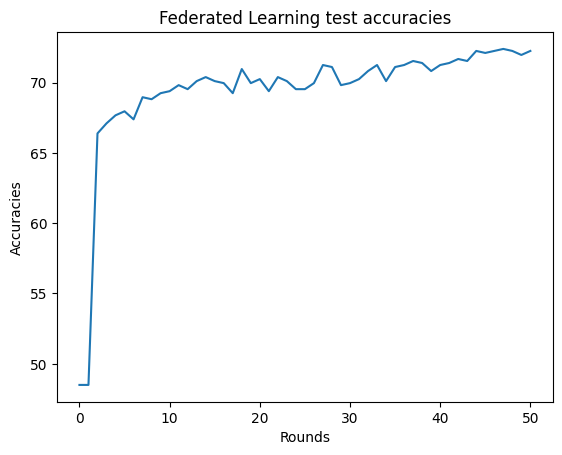

In [15]:
fl_acc
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')

In [16]:
max(fl_acc)

tensor(72.3891, device='cuda:0')

In [17]:
torch.save(net_FL.state_dict(), 'FL1c.pth')

# Transfer Learning

In [18]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "transfer learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config= {
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)
configuration_TL = dict(wandb.config)


/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


FL accuracy,▁▁▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇████████████
FL loss,█▆▄▄▃▃▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
FL accuracy,72.24606
FL loss,0.0474



Epoch 1/100
Epoch 1: Training accuracy: 49.033817291259766 Testing accuracy: 58.454105377197266.

Epoch 2/100
Epoch 2: Training accuracy: 60.62801742553711 Testing accuracy: 62.31884002685547.

Epoch 3/100
Epoch 3: Training accuracy: 63.949275970458984 Testing accuracy: 62.31884002685547.

Epoch 4/100
Epoch 4: Training accuracy: 65.94203186035156 Testing accuracy: 62.31884002685547.

Epoch 5/100
Epoch 5: Training accuracy: 67.51207733154297 Testing accuracy: 64.25120544433594.

Epoch 6/100
Epoch 6: Training accuracy: 69.20289611816406 Testing accuracy: 64.73429870605469.

Epoch 7/100
Epoch 7: Training accuracy: 70.65217590332031 Testing accuracy: 66.18357849121094.

Epoch 8/100
Epoch 8: Training accuracy: 71.1956558227539 Testing accuracy: 66.18357849121094.

Epoch 9/100
Epoch 9: Training accuracy: 71.73912811279297 Testing accuracy: 67.1497573852539.

Epoch 10/100
Epoch 10: Training accuracy: 71.79951477050781 Testing accuracy: 68.59903717041016.

Epoch 11/100
Epoch 11: Training accu

transfer training accuraccy,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
transfer validation accuracy,▁▂▃▄▅▅▅▅▆▅▆▆▇▆▇▇▇▇▇▅▆▇▇▇▇▇▇▇▇▇█▇▇███████
transfer training accuraccy,82.78986
transfer validation accuracy,77.29469


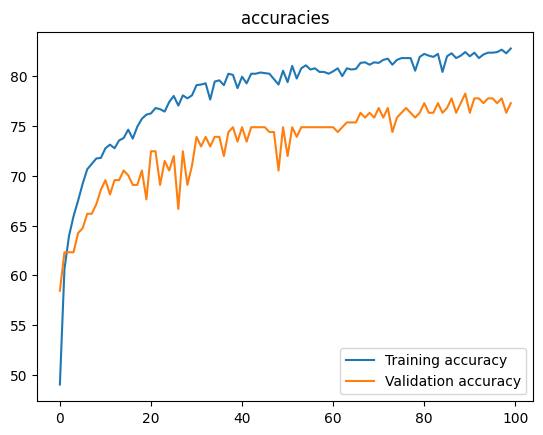

In [19]:
losses_transfer = []
accuracies_transfer = []
for epoch in range(1):
    train(net, azure_train_loaders_transfer, azure_val_loaders_transfer, configuration_TL, configuration_TL['epochs'], name= "transfer")
    loss, accuracy = test(net, azure_val_loaders_transfer, configuration_TL)
    losses_transfer.append(loss)
    accuracies_transfer.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
losses_transfer, accuracy_transfer = test(net, testloader, configuration=configuration_TL)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

In [20]:
torch.save(net.state_dict(), 'TL1c.pth')

# Federated Transfer Learning

In [21]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL one class",
    name= "federated transfer learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config=configuration
)

In [22]:
net_FTL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FTL, parameters_centralized)

In [23]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_FL(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FTL, trainloader, valloader, configuration).to_client()


In [24]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
ftl_acc = []
def evaluate(server_round,parameters,config):
    testloader = azure_test_loader
    set_parameters(net_FTL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FTL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    ftl_acc.append(accuracy)
    metrics = {'FTL loss': loss,
               "FTL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FTL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-08-19 01:05:58,506	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'accelerator_type:G': 1.0, 'GPU': 2.0, 'object_store_memory': 49464544051.0, 'node:192.168.1.146': 1.0, 'memory': 105417269453.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.07164897701957008 / accuracy 48.49785232543945
(ClientAppActor pid=1320832) 
(ClientAppActor pid=1320832) Epoch 1/100
(ClientAppActor pid=1320832) Epoch 1: Training accuracy: 51.28205108642578 Testing accuracy: 44.230770111083984.
(ClientAppActor pid=1320832) Epoch 2: Training accuracy: 48.71794891357422 Testing accuracy: 55.769229888916016.
(ClientAppActor pid=1320832)  [repeated 67x across cluster]
(ClientAppActor pid=1320832) Epoch 60/100 [repeated 67x across cluster]
(ClientAppActor pid=1320832) Epoch 79: Training accuracy: 51.28205108642578 Testing accuracy: 44.230770111083984. [repeated 86x across cluster]
(ClientAppActor pid=1320832)  [repeated 83x across cluster]
(ClientAppActor pid=1320832) Epoch 33/100 [repeated 83x across cluster]
(ClientAppActor pid=1320832) Epoch 55: Training accuracy: 49.63017654418945 Testing accuracy: 49.1124267578125. [repeated 86x across cluster]
(ClientAppActor pid=1320832)  [repeated 65x across cluster]
(ClientAppActor 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.06294957074252042, {'accuracy': tensor(56.0801, device='cuda:0')}, 58.629802099007065)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.06294957074252042 / accuracy 56.080116271972656


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320832)  [repeated 7x across cluster]
(ClientAppActor pid=1320832) Epoch 2/100 [repeated 7x across cluster]
(ClientAppActor pid=1320832) Epoch 3: Training accuracy: 50.59880065917969 Testing accuracy: 47.90419006347656. [repeated 9x across cluster]
(ClientAppActor pid=1320835)  [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 12/100 [repeated 24x across cluster]
(ClientAppActor pid=1320832) Epoch 17: Training accuracy: 57.11077880859375 Testing accuracy: 53.29341506958008. [repeated 24x across cluster]
(ClientAppActor pid=1320835)  [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 22/100 [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 23: Training accuracy: 61.09467315673828 Testing accuracy: 60.35503005981445. [repeated 24x across cluster]
(ClientAppActor pid=1320832)  [repeated 30x across cluster]
(ClientAppActor pid=1320832) Epoch 45/100 [repeated 30x across cluster]
(ClientAppActor pid=1320835) Epoch 38: Training 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.06119682030244307, {'accuracy': tensor(54.9356, device='cuda:0')}, 130.9498479830072)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.06119682030244307 / accuracy 54.93562316894531
(ClientAppActor pid=1320832)  [repeated 103x across cluster]
(ClientAppActor pid=1320832) Epoch 52/100 [repeated 103x across cluster]
(ClientAppActor pid=1320832) Epoch 51: Training accuracy: 71.67160034179688 Testing accuracy: 68.63905334472656. [repeated 102x across cluster]
(ClientAppActor pid=1320832)  [repeated 118x across cluster]
(ClientAppActor pid=1320832) Epoch 57/100 [repeated 118x across cluster]
(ClientAppActor pid=1320832) Epoch 56: Training accuracy: 63.46154022216797 Testing accuracy: 69.23076629638672. [repeated 118x across cluster]
(ClientAppActor pid=1320835)  [repeated 72x across cluster]
(ClientAppActor pid=1320835) Epoch 45/100 [repeated 72x across cluster]
(ClientAppActor pid=1320835) Epoch 44: Training accuracy: 69.61077880859375 Testing accuracy: 72.45509338378906. [repeated 73x across cluster]
(ClientAppActor pid=1320835)  [repeated 10x across cluster]
(ClientAppActor pid=1320835) Epo

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.05127310752868652, {'accuracy': tensor(71.6738, device='cuda:0')}, 170.23835488699842)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05127310752868652 / accuracy 71.67382049560547


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320832)  [repeated 12x across cluster]
(ClientAppActor pid=1320832) Epoch 7/100 [repeated 12x across cluster]
(ClientAppActor pid=1320832) Epoch 6: Training accuracy: 69.15680694580078 Testing accuracy: 68.0473403930664. [repeated 11x across cluster]
(ClientAppActor pid=1320835)  [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 12/100 [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 11: Training accuracy: 69.8353271484375 Testing accuracy: 60.479042053222656. [repeated 15x across cluster]
(ClientAppActor pid=1320835)  [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 19/100 [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 18: Training accuracy: 69.3113784790039 Testing accuracy: 71.25748443603516. [repeated 16x across cluster]
(ClientAppActor pid=1320832)  [repeated 14x across cluster]
(ClientAppActor pid=1320832) Epoch 32/100 [repeated 14x across cluster]
(ClientAppActor pid=1320832) Epoch 31: Training

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.05180619521574541, {'accuracy': tensor(70.9585, device='cuda:0')}, 248.28828007999982)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05180619521574541 / accuracy 70.95851135253906
(ClientAppActor pid=1320832)  [repeated 32x across cluster]
(ClientAppActor pid=1320832) Epoch 19/100 [repeated 32x across cluster]
(ClientAppActor pid=1320832) Epoch 18: Training accuracy: 73.42814636230469 Testing accuracy: 68.26347351074219. [repeated 31x across cluster]
(ClientAppActor pid=1320835)  [repeated 37x across cluster]
(ClientAppActor pid=1320835) Epoch 12/100 [repeated 37x across cluster]
(ClientAppActor pid=1320835) Epoch 11: Training accuracy: 74.2603530883789 Testing accuracy: 70.41419982910156. [repeated 37x across cluster]
(ClientAppActor pid=1320835)  [repeated 33x across cluster]
(ClientAppActor pid=1320835) Epoch 18/100 [repeated 33x across cluster]
(ClientAppActor pid=1320835) Epoch 17: Training accuracy: 74.03845977783203 Testing accuracy: 70.41419982910156. [repeated 33x across cluster]
(ClientAppActor pid=1320835)  [repeated 76x across cluster]
(ClientAppActor pid=1320835) Epoch 25/1

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 0.051353227008472786, {'accuracy': tensor(72.8183, device='cuda:0')}, 272.72486058301)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051353227008472786 / accuracy 72.81831359863281
(ClientAppActor pid=1320835)  [repeated 137x across cluster]
(ClientAppActor pid=1320835) Epoch 5/100 [repeated 137x across cluster]
(ClientAppActor pid=1320835) Epoch 4: Training accuracy: 72.59615325927734 Testing accuracy: 73.71794891357422. [repeated 137x across cluster]
(ClientAppActor pid=1320835)  [repeated 82x across cluster]
(ClientAppActor pid=1320835) Epoch 56/100 [repeated 82x across cluster]
(ClientAppActor pid=1320835) Epoch 55: Training accuracy: 77.32371520996094 Testing accuracy: 75.64102935791016. [repeated 82x across cluster]
(ClientAppActor pid=1320835)  [repeated 13x across cluster]
(ClientAppActor pid=1320835) Epoch 62/100 [repeated 13x across cluster]
(ClientAppActor pid=1320835) Epoch 61: Training accuracy: 77.48397064208984 Testing accuracy: 73.71794891357422. [repeated 13x across cluster]
(ClientAppActor pid=1320832)  [repeated 17x across cluster]
(ClientAppActor pid=1320832) Epoch 5

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (6, 0.052127702669663864, {'accuracy': tensor(67.9542, device='cuda:0')}, 377.9952523079992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.052127702669663864 / accuracy 67.9542236328125


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320832)  [repeated 12x across cluster]
(ClientAppActor pid=1320832) Epoch 5/100 [repeated 12x across cluster]
(ClientAppActor pid=1320832) Epoch 4: Training accuracy: 74.19871520996094 Testing accuracy: 74.35897064208984. [repeated 11x across cluster]
(ClientAppActor pid=1320832)  [repeated 31x across cluster]
(ClientAppActor pid=1320832) Epoch 27/100 [repeated 31x across cluster]
(ClientAppActor pid=1320832) Epoch 26: Training accuracy: 77.72435760498047 Testing accuracy: 75.64102935791016. [repeated 31x across cluster]
(ClientAppActor pid=1320835)  [repeated 28x across cluster]
(ClientAppActor pid=1320835) Epoch 19/100 [repeated 28x across cluster]
(ClientAppActor pid=1320835) Epoch 18: Training accuracy: 72.7544937133789 Testing accuracy: 65.26946258544922. [repeated 28x across cluster]
(ClientAppActor pid=1320835)  [repeated 30x across cluster]
(ClientAppActor pid=1320835) Epoch 30/100 [repeated 30x across cluster]
(ClientAppActor pid=1320835) Epoch 29: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (7, 0.05120925469831987, {'accuracy': tensor(72.6752, device='cuda:0')}, 411.4871955490089)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05120925469831987 / accuracy 72.67524719238281
(ClientAppActor pid=1320835)  [repeated 29x across cluster]
(ClientAppActor pid=1320835) Epoch 10/100 [repeated 29x across cluster]
(ClientAppActor pid=1320835) Epoch 9: Training accuracy: 77.81065368652344 Testing accuracy: 74.55621337890625. [repeated 28x across cluster]
(ClientAppActor pid=1320835)  [repeated 27x across cluster]
(ClientAppActor pid=1320835) Epoch 24/100 [repeated 27x across cluster]
(ClientAppActor pid=1320835) Epoch 23: Training accuracy: 78.99407958984375 Testing accuracy: 75.7396469116211. [repeated 27x across cluster]
(ClientAppActor pid=1320835)  [repeated 14x across cluster]
(ClientAppActor pid=1320835) Epoch 30/100 [repeated 14x across cluster]
(ClientAppActor pid=1320835) Epoch 29: Training accuracy: 79.58580017089844 Testing accuracy: 76.33135986328125. [repeated 14x across cluster]
(ClientAppActor pid=1320832)  [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 49/10

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (8, 0.0529342998157848, {'accuracy': tensor(73.2475, device='cuda:0')}, 503.448927275007)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.0529342998157848 / accuracy 73.24749755859375


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320832)  [repeated 11x across cluster]
(ClientAppActor pid=1320832) Epoch 1/100 [repeated 11x across cluster]
(ClientAppActor pid=1320832) Epoch 100: Training accuracy: 79.7275619506836 Testing accuracy: 76.92308044433594. [repeated 11x across cluster]
(ClientAppActor pid=1320835)  [repeated 25x across cluster]
(ClientAppActor pid=1320835) Epoch 13/100 [repeated 25x across cluster]
(ClientAppActor pid=1320835) Epoch 12: Training accuracy: 75.07396697998047 Testing accuracy: 71.00592041015625. [repeated 24x across cluster]
(ClientAppActor pid=1320832)  [repeated 30x across cluster]
(ClientAppActor pid=1320832) Epoch 26/100 [repeated 30x across cluster]
(ClientAppActor pid=1320832) Epoch 25: Training accuracy: 79.6474380493164 Testing accuracy: 76.92308044433594. [repeated 30x across cluster]
(ClientAppActor pid=1320835)  [repeated 35x across cluster]
(ClientAppActor pid=1320835) Epoch 54/100 [repeated 35x across cluster]
(ClientAppActor pid=1320835) Epoch 53: Traini

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (9, 0.05181828954003074, {'accuracy': tensor(72.9614, device='cuda:0')}, 532.71609704)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05181828954003074 / accuracy 72.96137237548828
(ClientAppActor pid=1320835)  [repeated 86x across cluster]
(ClientAppActor pid=1320835) Epoch 32/100 [repeated 86x across cluster]
(ClientAppActor pid=1320835) Epoch 31: Training accuracy: 75.37425231933594 Testing accuracy: 70.05988311767578. [repeated 85x across cluster]
(ClientAppActor pid=1320835)  [repeated 60x across cluster]
(ClientAppActor pid=1320835) Epoch 63/100 [repeated 60x across cluster]
(ClientAppActor pid=1320835) Epoch 62: Training accuracy: 75.74850463867188 Testing accuracy: 77.84431457519531. [repeated 60x across cluster]
(ClientAppActor pid=1320832)  [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 69/100 [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 68: Training accuracy: 79.96794891357422 Testing accuracy: 76.28205108642578. [repeated 16x across cluster]
(ClientAppActor pid=1320832)  [repeated 15x across cluster]
(ClientAppActor pid=1320832) Epoch 78/

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (10, 0.05141327056017789, {'accuracy': tensor(73.8197, device='cuda:0')}, 610.3480013020016)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05141327056017789 / accuracy 73.81974029541016
(ClientAppActor pid=1320835)  [repeated 41x across cluster]
(ClientAppActor pid=1320835) Epoch 12/100 [repeated 41x across cluster]
(ClientAppActor pid=1320835) Epoch 11: Training accuracy: 78.18047332763672 Testing accuracy: 74.55621337890625. [repeated 40x across cluster]
(ClientAppActor pid=1320832)  [repeated 68x across cluster]
(ClientAppActor pid=1320832) Epoch 64/100 [repeated 68x across cluster]
(ClientAppActor pid=1320832) Epoch 63: Training accuracy: 81.73076629638672 Testing accuracy: 78.20513153076172. [repeated 68x across cluster]
(ClientAppActor pid=1320832)  [repeated 40x across cluster]
(ClientAppActor pid=1320832) Epoch 92/100 [repeated 40x across cluster]
(ClientAppActor pid=1320832) Epoch 91: Training accuracy: 81.97115325927734 Testing accuracy: 76.92308044433594. [repeated 40x across cluster]
(ClientAppActor pid=1320835)  [repeated 31x across cluster]
(ClientAppActor pid=1320835) Epoch 54/

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (11, 0.05465036088770086, {'accuracy': tensor(72.1030, device='cuda:0')}, 666.4015001020016)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05465036088770086 / accuracy 72.1030044555664


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320835)  [repeated 18x across cluster]
(ClientAppActor pid=1320835) Epoch 7/100 [repeated 18x across cluster]
(ClientAppActor pid=1320835) Epoch 6: Training accuracy: 75.72115325927734 Testing accuracy: 76.92308044433594. [repeated 17x across cluster]
(ClientAppActor pid=1320832)  [repeated 26x across cluster]
(ClientAppActor pid=1320832) Epoch 23/100 [repeated 26x across cluster]
(ClientAppActor pid=1320832) Epoch 22: Training accuracy: 80.62129974365234 Testing accuracy: 78.10650634765625. [repeated 26x across cluster]
(ClientAppActor pid=1320832)  [repeated 27x across cluster]
(ClientAppActor pid=1320832) Epoch 39/100 [repeated 27x across cluster]
(ClientAppActor pid=1320832) Epoch 38: Training accuracy: 79.80769348144531 Testing accuracy: 77.5147933959961. [repeated 27x across cluster]
(ClientAppActor pid=1320835)  [repeated 14x across cluster]
(ClientAppActor pid=1320835) Epoch 35/100 [repeated 14x across cluster]
(ClientAppActor pid=1320835) Epoch 34: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (12, 0.05211189660159024, {'accuracy': tensor(74.6781, device='cuda:0')}, 738.0495255170099)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05211189660159024 / accuracy 74.67810821533203
(ClientAppActor pid=1320835)  [repeated 103x across cluster]
(ClientAppActor pid=1320835) Epoch 9/100 [repeated 103x across cluster]
(ClientAppActor pid=1320835) Epoch 8: Training accuracy: 79.96794891357422 Testing accuracy: 79.4871826171875. [repeated 102x across cluster]
(ClientAppActor pid=1320832)  [repeated 104x across cluster]
(ClientAppActor pid=1320832) Epoch 64/100 [repeated 104x across cluster]
(ClientAppActor pid=1320832) Epoch 63: Training accuracy: 78.69822692871094 Testing accuracy: 75.1479263305664. [repeated 104x across cluster]
(ClientAppActor pid=1320835)  [repeated 40x across cluster]
(ClientAppActor pid=1320835) Epoch 36/100 [repeated 40x across cluster]
(ClientAppActor pid=1320835) Epoch 35: Training accuracy: 81.57051086425781 Testing accuracy: 77.56410217285156. [repeated 40x across cluster]
(ClientAppActor pid=1320835)  [repeated 20x across cluster]
(ClientAppActor pid=1320835) Epoch 4

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (13, 0.05256367813457142, {'accuracy': tensor(72.5322, device='cuda:0')}, 778.1629899460095)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05256367813457142 / accuracy 72.53218841552734
(ClientAppActor pid=1320835)  [repeated 11x across cluster]
(ClientAppActor pid=1320835) Epoch 1/100 [repeated 11x across cluster]
(ClientAppActor pid=1320835) Epoch 100: Training accuracy: 82.69230651855469 Testing accuracy: 80.12820434570312. [repeated 11x across cluster]
(ClientAppActor pid=1320835)  [repeated 51x across cluster]
(ClientAppActor pid=1320835) Epoch 12/100 [repeated 51x across cluster]
(ClientAppActor pid=1320835) Epoch 11: Training accuracy: 77.36686706542969 Testing accuracy: 73.9645004272461. [repeated 50x across cluster]
(ClientAppActor pid=1320832)  [repeated 171x across cluster]
(ClientAppActor pid=1320832) Epoch 23/100 [repeated 171x across cluster]
(ClientAppActor pid=1320832) Epoch 22: Training accuracy: 77.72435760498047 Testing accuracy: 75.64102935791016. [repeated 172x across cluster]
(ClientAppActor pid=1320832)  [repeated 17x across cluster]
(ClientAppActor pid=1320832) Epoch 4

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (14, 0.05147582292556763, {'accuracy': tensor(73.9628, device='cuda:0')}, 825.0856591519987)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05147582292556763 / accuracy 73.96280670166016


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320832)  [repeated 10x across cluster]
(ClientAppActor pid=1320832) Epoch 1/100 [repeated 10x across cluster]
(ClientAppActor pid=1320832) Epoch 100: Training accuracy: 83.41345977783203 Testing accuracy: 80.12820434570312. [repeated 10x across cluster]
(ClientAppActor pid=1320835)  [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 8/100 [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 7: Training accuracy: 78.59281158447266 Testing accuracy: 82.63472747802734. [repeated 15x across cluster]
(ClientAppActor pid=1320835)  [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 14/100 [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 13: Training accuracy: 79.56586456298828 Testing accuracy: 82.63472747802734. [repeated 15x across cluster]
(ClientAppActor pid=1320835)  [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 21/100 [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 20: Traini

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (15, 0.050865335897965866, {'accuracy': tensor(74.6781, device='cuda:0')}, 894.928953228009)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.050865335897965866 / accuracy 74.67810821533203


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320832)  [repeated 26x across cluster]
(ClientAppActor pid=1320832) Epoch 16/100 [repeated 26x across cluster]
(ClientAppActor pid=1320832) Epoch 15: Training accuracy: 80.32544708251953 Testing accuracy: 77.5147933959961. [repeated 25x across cluster]
(ClientAppActor pid=1320835)  [repeated 31x across cluster]
(ClientAppActor pid=1320835) Epoch 19/100 [repeated 31x across cluster]
(ClientAppActor pid=1320835) Epoch 18: Training accuracy: 81.81089782714844 Testing accuracy: 80.12820434570312. [repeated 31x across cluster]
(ClientAppActor pid=1320832)  [repeated 34x across cluster]
(ClientAppActor pid=1320832) Epoch 57/100 [repeated 34x across cluster]
(ClientAppActor pid=1320832) Epoch 56: Training accuracy: 81.87870025634766 Testing accuracy: 78.69822692871094. [repeated 34x across cluster]
(ClientAppActor pid=1320835)  [repeated 53x across cluster]
(ClientAppActor pid=1320835) Epoch 51/100 [repeated 53x across cluster]
(ClientAppActor pid=1320835) Epoch 50: Train

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (16, 0.05288088321685791, {'accuracy': tensor(71.8169, device='cuda:0')}, 920.7416212090029)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05288088321685791 / accuracy 71.81687927246094
(ClientAppActor pid=1320835)  [repeated 58x across cluster]
(ClientAppActor pid=1320835) Epoch 11/100 [repeated 58x across cluster]
(ClientAppActor pid=1320835) Epoch 10: Training accuracy: 76.87125396728516 Testing accuracy: 73.65269470214844. [repeated 58x across cluster]
(ClientAppActor pid=1320832)  [repeated 42x across cluster]
(ClientAppActor pid=1320832) Epoch 42/100 [repeated 42x across cluster]
(ClientAppActor pid=1320832) Epoch 41: Training accuracy: 82.24851989746094 Testing accuracy: 79.2899398803711. [repeated 42x across cluster]
(ClientAppActor pid=1320832)  [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 51/100 [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 50: Training accuracy: 82.61833953857422 Testing accuracy: 79.2899398803711. [repeated 16x across cluster]
(ClientAppActor pid=1320835)  [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 45/10

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (17, 0.050418485294688835, {'accuracy': tensor(74.8212, device='cuda:0')}, 998.4994769220066)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.050418485294688835 / accuracy 74.82117462158203
(ClientAppActor pid=1320832)  [repeated 21x across cluster]
(ClientAppActor pid=1320832) Epoch 11/100 [repeated 21x across cluster]
(ClientAppActor pid=1320832) Epoch 10: Training accuracy: 78.74251556396484 Testing accuracy: 80.83832550048828. [repeated 20x across cluster]
(ClientAppActor pid=1320832)  [repeated 24x across cluster]
(ClientAppActor pid=1320832) Epoch 25/100 [repeated 24x across cluster]
(ClientAppActor pid=1320832) Epoch 24: Training accuracy: 82.03592681884766 Testing accuracy: 82.03592681884766. [repeated 24x across cluster]
(ClientAppActor pid=1320835)  [repeated 44x across cluster]
(ClientAppActor pid=1320835) Epoch 30/100 [repeated 44x across cluster]
(ClientAppActor pid=1320835) Epoch 29: Training accuracy: 83.17308044433594 Testing accuracy: 78.84615325927734. [repeated 44x across cluster]
(ClientAppActor pid=1320835)  [repeated 33x across cluster]
(ClientAppActor pid=1320835) Epoch 42

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (18, 0.0500967719338157, {'accuracy': tensor(74.9642, device='cuda:0')}, 1063.775258905007)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.0500967719338157 / accuracy 74.9642333984375


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320835)  [repeated 7x across cluster]
(ClientAppActor pid=1320835) Epoch 2/100 [repeated 7x across cluster]
(ClientAppActor pid=1320835) Epoch 1: Training accuracy: 76.20191955566406 Testing accuracy: 76.28205108642578. [repeated 6x across cluster]
(ClientAppActor pid=1320835)  [repeated 20x across cluster]
(ClientAppActor pid=1320835) Epoch 12/100 [repeated 20x across cluster]
(ClientAppActor pid=1320835) Epoch 11: Training accuracy: 81.81089782714844 Testing accuracy: 80.76923370361328. [repeated 20x across cluster]
(ClientAppActor pid=1320835)  [repeated 18x across cluster]
(ClientAppActor pid=1320835) Epoch 22/100 [repeated 18x across cluster]
(ClientAppActor pid=1320835) Epoch 21: Training accuracy: 81.81089782714844 Testing accuracy: 80.12820434570312. [repeated 18x across cluster]
(ClientAppActor pid=1320835)  [repeated 19x across cluster]
(ClientAppActor pid=1320835) Epoch 30/100 [repeated 19x across cluster]
(ClientAppActor pid=1320835) Epoch 29: Training 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (19, 0.049483624371615326, {'accuracy': tensor(74.2489, device='cuda:0')}, 1148.5982805970125)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.049483624371615326 / accuracy 74.2489242553711
(ClientAppActor pid=1320835)  [repeated 8x across cluster]
(ClientAppActor pid=1320835) Epoch 1/100 [repeated 8x across cluster]
(ClientAppActor pid=1320832) Epoch 100: Training accuracy: 82.3224868774414 Testing accuracy: 79.88166046142578. [repeated 7x across cluster]
(ClientAppActor pid=1320832)  [repeated 14x across cluster]
(ClientAppActor pid=1320832) Epoch 9/100 [repeated 14x across cluster]
(ClientAppActor pid=1320832) Epoch 8: Training accuracy: 81.36094665527344 Testing accuracy: 77.5147933959961. [repeated 14x across cluster]
(ClientAppActor pid=1320835)  [repeated 17x across cluster]
(ClientAppActor pid=1320835) Epoch 15/100 [repeated 17x across cluster]
(ClientAppActor pid=1320835) Epoch 14: Training accuracy: 81.25 Testing accuracy: 78.20513153076172. [repeated 17x across cluster]
(ClientAppActor pid=1320832)  [repeated 15x across cluster]
(ClientAppActor pid=1320832) Epoch 27/100 [repeated 15x a

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (20, 0.052069008350372314, {'accuracy': tensor(73.3906, device='cuda:0')}, 1193.6128515940072)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.052069008350372314 / accuracy 73.39055633544922
(ClientAppActor pid=1320835)  [repeated 92x across cluster]
(ClientAppActor pid=1320835) Epoch 30/100 [repeated 92x across cluster]
(ClientAppActor pid=1320835) Epoch 29: Training accuracy: 83.57371520996094 Testing accuracy: 79.4871826171875. [repeated 91x across cluster]
(ClientAppActor pid=1320835)  [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 37/100 [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 36: Training accuracy: 83.0128173828125 Testing accuracy: 79.4871826171875. [repeated 16x across cluster]
(ClientAppActor pid=1320835)  [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 44/100 [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 43: Training accuracy: 82.8525619506836 Testing accuracy: 79.4871826171875. [repeated 15x across cluster]
(ClientAppActor pid=1320835)  [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 51/100 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (21, 0.049415360797535286, {'accuracy': tensor(74.6781, device='cuda:0')}, 1290.1885782169993)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.049415360797535286 / accuracy 74.67810821533203
(ClientAppActor pid=1320835)  [repeated 11x across cluster]
(ClientAppActor pid=1320835) Epoch 1/100 [repeated 11x across cluster]
(ClientAppActor pid=1320832) Epoch 100: Training accuracy: 81.73076629638672 Testing accuracy: 78.69822692871094. [repeated 11x across cluster]
(ClientAppActor pid=1320835)  [repeated 32x across cluster]
(ClientAppActor pid=1320835) Epoch 21/100 [repeated 32x across cluster]
(ClientAppActor pid=1320835) Epoch 20: Training accuracy: 80.1646728515625 Testing accuracy: 83.23353576660156. [repeated 31x across cluster]
(ClientAppActor pid=1320835)  [repeated 31x across cluster]
(ClientAppActor pid=1320835) Epoch 39/100 [repeated 31x across cluster]
(ClientAppActor pid=1320835) Epoch 38: Training accuracy: 82.78443145751953 Testing accuracy: 82.03592681884766. [repeated 31x across cluster]
(ClientAppActor pid=1320835)  [repeated 36x across cluster]
(ClientAppActor pid=1320835) Epoch 57/

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (22, 0.051423257047479805, {'accuracy': tensor(72.5322, device='cuda:0')}, 1377.638434004999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051423257047479805 / accuracy 72.53218841552734
(ClientAppActor pid=1320832)  [repeated 21x across cluster]
(ClientAppActor pid=1320832) Epoch 7/100 [repeated 21x across cluster]
(ClientAppActor pid=1320832) Epoch 6: Training accuracy: 81.28697967529297 Testing accuracy: 79.2899398803711. [repeated 20x across cluster]
(ClientAppActor pid=1320835)  [repeated 72x across cluster]
(ClientAppActor pid=1320835) Epoch 10/100 [repeated 72x across cluster]
(ClientAppActor pid=1320835) Epoch 9: Training accuracy: 82.8525619506836 Testing accuracy: 80.76923370361328. [repeated 72x across cluster]
(ClientAppActor pid=1320832)  [repeated 95x across cluster]
(ClientAppActor pid=1320832) Epoch 57/100 [repeated 95x across cluster]
(ClientAppActor pid=1320832) Epoch 56: Training accuracy: 82.26048278808594 Testing accuracy: 77.84431457519531. [repeated 95x across cluster]
(ClientAppActor pid=1320835)  [repeated 54x across cluster]
(ClientAppActor pid=1320835) Epoch 31/100 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (23, 0.049809802662242546, {'accuracy': tensor(74.3920, device='cuda:0')}, 1432.0602669910004)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.049809802662242546 / accuracy 74.3919906616211
(ClientAppActor pid=1320835)  [repeated 21x across cluster]
(ClientAppActor pid=1320835) Epoch 5/100 [repeated 21x across cluster]
(ClientAppActor pid=1320835) Epoch 4: Training accuracy: 76.84911346435547 Testing accuracy: 73.9645004272461. [repeated 20x across cluster]
(ClientAppActor pid=1320835)  [repeated 210x across cluster]
(ClientAppActor pid=1320835) Epoch 29/100 [repeated 210x across cluster]
(ClientAppActor pid=1320835) Epoch 28: Training accuracy: 78.3682632446289 Testing accuracy: 74.85029602050781. [repeated 210x across cluster]
(ClientAppActor pid=1320835)  [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 46/100 [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 45: Training accuracy: 82.18563079833984 Testing accuracy: 78.443115234375. [repeated 25x across cluster]
(ClientAppActor pid=1320835)  [repeated 8x across cluster]
(ClientAppActor pid=1320835) Epoch 54/100 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (24, 0.050911041823300446, {'accuracy': tensor(74.2489, device='cuda:0')}, 1485.7123473090032)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=1320835)  [repeated 7x across cluster]
(ClientAppActor pid=1320835) Epoch 100/100 [repeated 7x across cluster]
(ClientAppActor pid=1320835) Epoch 100: Training accuracy: 82.26048278808594 Testing accuracy: 79.64071655273438. [repeated 8x across cluster]
Server-side evaluation loss 0.050911041823300446 / accuracy 74.2489242553711


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320835)  [repeated 17x across cluster]
(ClientAppActor pid=1320835) Epoch 6/100 [repeated 17x across cluster]
(ClientAppActor pid=1320835) Epoch 5: Training accuracy: 82.37179565429688 Testing accuracy: 80.76923370361328. [repeated 15x across cluster]
(ClientAppActor pid=1320832)  [repeated 19x across cluster]
(ClientAppActor pid=1320832) Epoch 23/100 [repeated 19x across cluster]
(ClientAppActor pid=1320832) Epoch 22: Training accuracy: 81.9526596069336 Testing accuracy: 79.88166046142578. [repeated 19x across cluster]
(ClientAppActor pid=1320832)  [repeated 22x across cluster]
(ClientAppActor pid=1320832) Epoch 39/100 [repeated 22x across cluster]
(ClientAppActor pid=1320832) Epoch 38: Training accuracy: 82.3224868774414 Testing accuracy: 80.47337341308594. [repeated 22x across cluster]
(ClientAppActor pid=1320835)  [repeated 55x across cluster]
(ClientAppActor pid=1320835) Epoch 29/100 [repeated 55x across cluster]
(ClientAppActor pid=1320835) Epoch 28: Training

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (25, 0.050854135643352165, {'accuracy': tensor(73.6767, device='cuda:0')}, 1547.2473154530016)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.050854135643352165 / accuracy 73.67668151855469
(ClientAppActor pid=1320835)  [repeated 13x across cluster]
(ClientAppActor pid=1320835) Epoch 1/100 [repeated 13x across cluster]
(ClientAppActor pid=1320835) Epoch 100: Training accuracy: 84.13461303710938 Testing accuracy: 81.4102554321289. [repeated 13x across cluster]
(ClientAppActor pid=1320832)  [repeated 19x across cluster]
(ClientAppActor pid=1320832) Epoch 9/100 [repeated 19x across cluster]
(ClientAppActor pid=1320832) Epoch 8: Training accuracy: 81.80473327636719 Testing accuracy: 79.2899398803711. [repeated 18x across cluster]
(ClientAppActor pid=1320835)  [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 21/100 [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 20: Training accuracy: 83.17308044433594 Testing accuracy: 80.12820434570312. [repeated 24x across cluster]
(ClientAppActor pid=1320835)  [repeated 23x across cluster]
(ClientAppActor pid=1320835) Epoch 32/100

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (26, 0.05087241259488193, {'accuracy': tensor(74.3920, device='cuda:0')}, 1637.6639850720094)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05087241259488193 / accuracy 74.3919906616211
(ClientAppActor pid=1320832)  [repeated 41x across cluster]
(ClientAppActor pid=1320832) Epoch 26/100 [repeated 41x across cluster]
(ClientAppActor pid=1320832) Epoch 25: Training accuracy: 83.23353576660156 Testing accuracy: 83.83233642578125. [repeated 40x across cluster]
(ClientAppActor pid=1320832)  [repeated 82x across cluster]
(ClientAppActor pid=1320832) Epoch 89/100 [repeated 82x across cluster]
(ClientAppActor pid=1320832) Epoch 88: Training accuracy: 82.18563079833984 Testing accuracy: 83.23353576660156. [repeated 82x across cluster]
(ClientAppActor pid=1320835)  [repeated 34x across cluster]
(ClientAppActor pid=1320835) Epoch 50/100 [repeated 34x across cluster]
(ClientAppActor pid=1320835) Epoch 49: Training accuracy: 82.91419982910156 Testing accuracy: 79.88166046142578. [repeated 34x across cluster]
(ClientAppActor pid=1320835)  [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 57/1

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (27, 0.05028225075114857, {'accuracy': tensor(73.9628, device='cuda:0')}, 1704.738762880006)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05028225075114857 / accuracy 73.96280670166016
(ClientAppActor pid=1320832)  [repeated 23x across cluster]
(ClientAppActor pid=1320832) Epoch 14/100 [repeated 23x across cluster]
(ClientAppActor pid=1320832) Epoch 13: Training accuracy: 82.11077880859375 Testing accuracy: 83.83233642578125. [repeated 22x across cluster]
(ClientAppActor pid=1320835)  [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 20/100 [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 19: Training accuracy: 84.2147445678711 Testing accuracy: 80.76923370361328. [repeated 24x across cluster]
(ClientAppActor pid=1320832)  [repeated 27x across cluster]
(ClientAppActor pid=1320832) Epoch 44/100 [repeated 27x across cluster]
(ClientAppActor pid=1320832) Epoch 43: Training accuracy: 82.18563079833984 Testing accuracy: 79.04191589355469. [repeated 27x across cluster]
(ClientAppActor pid=1320832)  [repeated 22x across cluster]
(ClientAppActor pid=1320832) Epoch 57/1

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (28, 0.050702907822348854, {'accuracy': tensor(74.3920, device='cuda:0')}, 1763.7067576260015)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.050702907822348854 / accuracy 74.3919906616211


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320835)  [repeated 13x across cluster]
(ClientAppActor pid=1320835) Epoch 5/100 [repeated 13x across cluster]
(ClientAppActor pid=1320835) Epoch 4: Training accuracy: 82.93269348144531 Testing accuracy: 80.12820434570312. [repeated 12x across cluster]
(ClientAppActor pid=1320835)  [repeated 25x across cluster]
(ClientAppActor pid=1320835) Epoch 16/100 [repeated 25x across cluster]
(ClientAppActor pid=1320835) Epoch 15: Training accuracy: 83.89423370361328 Testing accuracy: 80.76923370361328. [repeated 25x across cluster]
(ClientAppActor pid=1320835)  [repeated 25x across cluster]
(ClientAppActor pid=1320835) Epoch 27/100 [repeated 25x across cluster]
(ClientAppActor pid=1320835) Epoch 26: Training accuracy: 83.89423370361328 Testing accuracy: 81.4102554321289. [repeated 25x across cluster]
(ClientAppActor pid=1320832)  [repeated 27x across cluster]
(ClientAppActor pid=1320832) Epoch 50/100 [repeated 27x across cluster]
(ClientAppActor pid=1320832) Epoch 49: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (29, 0.050017243081873115, {'accuracy': tensor(73.9628, device='cuda:0')}, 1844.1290356130048)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.050017243081873115 / accuracy 73.96280670166016
(ClientAppActor pid=1320835)  [repeated 61x across cluster]
(ClientAppActor pid=1320835) Epoch 1/100 [repeated 61x across cluster]
(ClientAppActor pid=1320832) Epoch 8: Training accuracy: 83.49359130859375 Testing accuracy: 79.4871826171875. [repeated 60x across cluster]
(ClientAppActor pid=1320832)  [repeated 140x across cluster]
(ClientAppActor pid=1320832) Epoch 40/100 [repeated 140x across cluster]
(ClientAppActor pid=1320832) Epoch 39: Training accuracy: 82.39644622802734 Testing accuracy: 80.47337341308594. [repeated 140x across cluster]
(ClientAppActor pid=1320835)  [repeated 75x across cluster]
(ClientAppActor pid=1320835) Epoch 25/100 [repeated 75x across cluster]
(ClientAppActor pid=1320835) Epoch 24: Training accuracy: 82.55988311767578 Testing accuracy: 82.03592681884766. [repeated 76x across cluster]
(ClientAppActor pid=1320835)  [repeated 12x across cluster]
(ClientAppActor pid=1320835) Epoch 37

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (30, 0.050575445998798714, {'accuracy': tensor(74.5350, device='cuda:0')}, 1894.2765993700013)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.050575445998798714 / accuracy 74.53504943847656
(ClientAppActor pid=1320835)  [repeated 43x across cluster]
(ClientAppActor pid=1320835) Epoch 19/100 [repeated 43x across cluster]
(ClientAppActor pid=1320835) Epoch 18: Training accuracy: 83.81410217285156 Testing accuracy: 80.76923370361328. [repeated 42x across cluster]
(ClientAppActor pid=1320835)  [repeated 198x across cluster]
(ClientAppActor pid=1320835) Epoch 37/100 [repeated 198x across cluster]
(ClientAppActor pid=1320835) Epoch 36: Training accuracy: 82.98816680908203 Testing accuracy: 79.88166046142578. [repeated 198x across cluster]
(ClientAppActor pid=1320835)  [repeated 26x across cluster]
(ClientAppActor pid=1320835) Epoch 59/100 [repeated 26x across cluster]
(ClientAppActor pid=1320835) Epoch 58: Training accuracy: 82.98816680908203 Testing accuracy: 78.69822692871094. [repeated 27x across cluster]
(ClientAppActor pid=1320835)  [repeated 6x across cluster]
(ClientAppActor pid=1320835) Epoch 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (31, 0.04912340099161321, {'accuracy': tensor(75.2504, device='cuda:0')}, 1942.820487902005)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.04912340099161321 / accuracy 75.25035858154297


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320832)  [repeated 10x across cluster]
(ClientAppActor pid=1320832) Epoch 5/100 [repeated 10x across cluster]
(ClientAppActor pid=1320832) Epoch 4: Training accuracy: 82.03592681884766 Testing accuracy: 83.23353576660156. [repeated 9x across cluster]
(ClientAppActor pid=1320832)  [repeated 14x across cluster]
(ClientAppActor pid=1320832) Epoch 13/100 [repeated 14x across cluster]
(ClientAppActor pid=1320832) Epoch 12: Training accuracy: 83.38323211669922 Testing accuracy: 82.63472747802734. [repeated 14x across cluster]
(ClientAppActor pid=1320835)  [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 16/100 [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 15: Training accuracy: 82.47041320800781 Testing accuracy: 80.47337341308594. [repeated 16x across cluster]
(ClientAppActor pid=1320832)  [repeated 15x across cluster]
(ClientAppActor pid=1320832) Epoch 31/100 [repeated 15x across cluster]
(ClientAppActor pid=1320832) Epoch 30: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (32, 0.051216743209145286, {'accuracy': tensor(73.8197, device='cuda:0')}, 1999.529791591005)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051216743209145286 / accuracy 73.81974029541016
(ClientAppActor pid=1320835)  [repeated 19x across cluster]
(ClientAppActor pid=1320835) Epoch 6/100 [repeated 19x across cluster]
(ClientAppActor pid=1320835) Epoch 5: Training accuracy: 82.47041320800781 Testing accuracy: 79.88166046142578. [repeated 18x across cluster]
(ClientAppActor pid=1320832)  [repeated 15x across cluster]
(ClientAppActor pid=1320832) Epoch 13/100 [repeated 15x across cluster]
(ClientAppActor pid=1320832) Epoch 12: Training accuracy: 83.15868377685547 Testing accuracy: 83.83233642578125. [repeated 15x across cluster]
(ClientAppActor pid=1320835)  [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 19/100 [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 18: Training accuracy: 82.69230651855469 Testing accuracy: 81.0650863647461. [repeated 16x across cluster]
(ClientAppActor pid=1320835)  [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 25/10

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (33, 0.050502218983390114, {'accuracy': tensor(74.8212, device='cuda:0')}, 2079.3495095320104)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.050502218983390114 / accuracy 74.82117462158203
(ClientAppActor pid=1320832)  [repeated 21x across cluster]
(ClientAppActor pid=1320832) Epoch 4/100 [repeated 21x across cluster]
(ClientAppActor pid=1320832) Epoch 3: Training accuracy: 81.21257781982422 Testing accuracy: 83.23353576660156. [repeated 20x across cluster]
(ClientAppActor pid=1320832)  [repeated 28x across cluster]
(ClientAppActor pid=1320832) Epoch 26/100 [repeated 28x across cluster]
(ClientAppActor pid=1320832) Epoch 25: Training accuracy: 83.9820327758789 Testing accuracy: 83.23353576660156. [repeated 28x across cluster]
(ClientAppActor pid=1320835)  [repeated 26x across cluster]
(ClientAppActor pid=1320835) Epoch 14/100 [repeated 26x across cluster]
(ClientAppActor pid=1320835) Epoch 13: Training accuracy: 82.39644622802734 Testing accuracy: 80.47337341308594. [repeated 26x across cluster]
(ClientAppActor pid=1320832)  [repeated 29x across cluster]
(ClientAppActor pid=1320832) Epoch 69/10

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (34, 0.05016846006566828, {'accuracy': tensor(74.3920, device='cuda:0')}, 2112.817694889003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05016846006566828 / accuracy 74.3919906616211
(ClientAppActor pid=1320835)  [repeated 92x across cluster]
(ClientAppActor pid=1320835) Epoch 31/100 [repeated 92x across cluster]
(ClientAppActor pid=1320835) Epoch 30: Training accuracy: 83.2100601196289 Testing accuracy: 80.47337341308594. [repeated 91x across cluster]
(ClientAppActor pid=1320832)  [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 38/100 [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 37: Training accuracy: 84.05448913574219 Testing accuracy: 80.76923370361328. [repeated 16x across cluster]
(ClientAppActor pid=1320835)  [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 44/100 [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 43: Training accuracy: 83.65384674072266 Testing accuracy: 81.0650863647461. [repeated 15x across cluster]
(ClientAppActor pid=1320832)  [repeated 17x across cluster]
(ClientAppActor pid=1320832) Epoch 57/100

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (35, 0.050382895903153854, {'accuracy': tensor(74.8212, device='cuda:0')}, 2201.1884737810033)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.050382895903153854 / accuracy 74.82117462158203
(ClientAppActor pid=1320835)  [repeated 34x across cluster]
(ClientAppActor pid=1320835) Epoch 13/100 [repeated 34x across cluster]
(ClientAppActor pid=1320835) Epoch 12: Training accuracy: 82.91419982910156 Testing accuracy: 78.10650634765625. [repeated 33x across cluster]
(ClientAppActor pid=1320835)  [repeated 33x across cluster]
(ClientAppActor pid=1320835) Epoch 25/100 [repeated 33x across cluster]
(ClientAppActor pid=1320835) Epoch 24: Training accuracy: 82.76627349853516 Testing accuracy: 80.47337341308594. [repeated 33x across cluster]
(ClientAppActor pid=1320835)  [repeated 31x across cluster]
(ClientAppActor pid=1320835) Epoch 36/100 [repeated 31x across cluster]
(ClientAppActor pid=1320835) Epoch 35: Training accuracy: 80.10355377197266 Testing accuracy: 75.1479263305664. [repeated 31x across cluster]
(ClientAppActor pid=1320835)  [repeated 31x across cluster]
(ClientAppActor pid=1320835) Epoch 46/

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1320832)  [repeated 9x across cluster]
(ClientAppActor pid=1320832) Epoch 100/100 [repeated 9x across cluster]
(ClientAppActor pid=1320832) Epoch 100: Training accuracy: 79.71556854248047 Testing accuracy: 74.85029602050781. [repeated 10x across cluster]


INFO :      fit progress: (36, 0.05038895390250466, {'accuracy': tensor(75.1073, device='cuda:0')}, 2268.7830588450015)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05038895390250466 / accuracy 75.1072998046875


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320835)  [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 7/100 [repeated 15x across cluster]
(ClientAppActor pid=1320835) Epoch 6: Training accuracy: 82.55988311767578 Testing accuracy: 81.43712615966797. [repeated 13x across cluster]
(ClientAppActor pid=1320832)  [repeated 14x across cluster]
(ClientAppActor pid=1320832) Epoch 16/100 [repeated 14x across cluster]
(ClientAppActor pid=1320832) Epoch 15: Training accuracy: 83.0621337890625 Testing accuracy: 80.47337341308594. [repeated 14x across cluster]
(ClientAppActor pid=1320832)  [repeated 18x across cluster]
(ClientAppActor pid=1320832) Epoch 27/100 [repeated 18x across cluster]
(ClientAppActor pid=1320832) Epoch 26: Training accuracy: 83.43195343017578 Testing accuracy: 80.47337341308594. [repeated 18x across cluster]
(ClientAppActor pid=1320832)  [repeated 19x across cluster]
(ClientAppActor pid=1320832) Epoch 40/100 [repeated 19x across cluster]
(ClientAppActor pid=1320832) Epoch 39: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (37, 0.050287355076182975, {'accuracy': tensor(75.5365, device='cuda:0')}, 2335.7980797780037)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.050287355076182975 / accuracy 75.53648376464844


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320835)  [repeated 12x across cluster]
(ClientAppActor pid=1320835) Epoch 1/100 [repeated 12x across cluster]
(ClientAppActor pid=1320835) Epoch 100: Training accuracy: 81.8113784790039 Testing accuracy: 83.23353576660156. [repeated 12x across cluster]
(ClientAppActor pid=1320832)  [repeated 34x across cluster]
(ClientAppActor pid=1320832) Epoch 22/100 [repeated 34x across cluster]
(ClientAppActor pid=1320832) Epoch 21: Training accuracy: 84.93589782714844 Testing accuracy: 82.05128479003906. [repeated 33x across cluster]
(ClientAppActor pid=1320835)  [repeated 41x across cluster]
(ClientAppActor pid=1320835) Epoch 25/100 [repeated 41x across cluster]
(ClientAppActor pid=1320835) Epoch 24: Training accuracy: 83.5329360961914 Testing accuracy: 82.63472747802734. [repeated 41x across cluster]
(ClientAppActor pid=1320832)  [repeated 32x across cluster]
(ClientAppActor pid=1320832) Epoch 73/100 [repeated 32x across cluster]
(ClientAppActor pid=1320832) Epoch 72: Traini

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (38, 0.051440417766571045, {'accuracy': tensor(74.2489, device='cuda:0')}, 2364.3098428390076)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051440417766571045 / accuracy 74.2489242553711
(ClientAppActor pid=1320835)  [repeated 98x across cluster]
(ClientAppActor pid=1320835) Epoch 41/100 [repeated 98x across cluster]
(ClientAppActor pid=1320835) Epoch 40: Training accuracy: 83.0621337890625 Testing accuracy: 80.47337341308594. [repeated 97x across cluster]
(ClientAppActor pid=1320832)  [repeated 17x across cluster]
(ClientAppActor pid=1320832) Epoch 41/100 [repeated 17x across cluster]
(ClientAppActor pid=1320832) Epoch 40: Training accuracy: 84.375 Testing accuracy: 82.05128479003906. [repeated 17x across cluster]
(ClientAppActor pid=1320832)  [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 50/100 [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 49: Training accuracy: 84.375 Testing accuracy: 82.69230651855469. [repeated 16x across cluster]
(ClientAppActor pid=1320832)  [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 60/100 [repeated 16x acros

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (39, 0.05039700594815341, {'accuracy': tensor(75.6795, device='cuda:0')}, 2447.4696679810004)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05039700594815341 / accuracy 75.6795425415039
(ClientAppActor pid=1320835)  [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 6/100 [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 5: Training accuracy: 81.21302032470703 Testing accuracy: 78.69822692871094. [repeated 23x across cluster]
(ClientAppActor pid=1320835)  [repeated 21x across cluster]
(ClientAppActor pid=1320835) Epoch 14/100 [repeated 21x across cluster]
(ClientAppActor pid=1320835) Epoch 13: Training accuracy: 83.35798645019531 Testing accuracy: 79.2899398803711. [repeated 21x across cluster]
(ClientAppActor pid=1320832)  [repeated 21x across cluster]
(ClientAppActor pid=1320832) Epoch 35/100 [repeated 21x across cluster]
(ClientAppActor pid=1320832) Epoch 34: Training accuracy: 84.375 Testing accuracy: 83.33333587646484. [repeated 21x across cluster]
(ClientAppActor pid=1320832)  [repeated 22x across cluster]
(ClientAppActor pid=1320832) Epoch 47/100 [repeated 2

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (40, 0.05254243178801103, {'accuracy': tensor(74.1059, device='cuda:0')}, 2535.5015050190123)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05254243178801103 / accuracy 74.10586547851562


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320835)  [repeated 18x across cluster]
(ClientAppActor pid=1320835) Epoch 7/100 [repeated 18x across cluster]
(ClientAppActor pid=1320835) Epoch 6: Training accuracy: 80.1646728515625 Testing accuracy: 81.43712615966797. [repeated 17x across cluster]
(ClientAppActor pid=1320832)  [repeated 21x across cluster]
(ClientAppActor pid=1320832) Epoch 24/100 [repeated 21x across cluster]
(ClientAppActor pid=1320832) Epoch 23: Training accuracy: 83.57987976074219 Testing accuracy: 80.47337341308594. [repeated 21x across cluster]
(ClientAppActor pid=1320832)  [repeated 28x across cluster]
(ClientAppActor pid=1320832) Epoch 44/100 [repeated 28x across cluster]
(ClientAppActor pid=1320832) Epoch 43: Training accuracy: 83.50592041015625 Testing accuracy: 79.88166046142578. [repeated 28x across cluster]
(ClientAppActor pid=1320832)  [repeated 30x across cluster]
(ClientAppActor pid=1320832) Epoch 65/100 [repeated 30x across cluster]
(ClientAppActor pid=1320832) Epoch 64: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (41, 0.04973528060046109, {'accuracy': tensor(75.3934, device='cuda:0')}, 2567.244988877006)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.04973528060046109 / accuracy 75.39341735839844
(ClientAppActor pid=1320835)  [repeated 150x across cluster]
(ClientAppActor pid=1320835) Epoch 76/100 [repeated 150x across cluster]
(ClientAppActor pid=1320835) Epoch 75: Training accuracy: 83.13609313964844 Testing accuracy: 78.69822692871094. [repeated 150x across cluster]
(ClientAppActor pid=1320832)  [repeated 28x across cluster]
(ClientAppActor pid=1320832) Epoch 49/100 [repeated 28x across cluster]
(ClientAppActor pid=1320832) Epoch 48: Training accuracy: 84.45513153076172 Testing accuracy: 80.76923370361328. [repeated 28x across cluster]
(ClientAppActor pid=1320835)  [repeated 21x across cluster]
(ClientAppActor pid=1320835) Epoch 94/100 [repeated 21x across cluster]
(ClientAppActor pid=1320835) Epoch 93: Training accuracy: 83.72781372070312 Testing accuracy: 79.2899398803711. [repeated 21x across cluster]
(ClientAppActor pid=1320832)  [repeated 15x across cluster]
(ClientAppActor pid=1320832) Epoch 7

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (42, 0.05090774731202559, {'accuracy': tensor(74.8212, device='cuda:0')}, 2652.0615471050114)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05090774731202559 / accuracy 74.82117462158203
(ClientAppActor pid=1320832)  [repeated 44x across cluster]
(ClientAppActor pid=1320832) Epoch 21/100 [repeated 44x across cluster]
(ClientAppActor pid=1320832) Epoch 20: Training accuracy: 83.23353576660156 Testing accuracy: 82.03592681884766. [repeated 43x across cluster]
(ClientAppActor pid=1320835)  [repeated 36x across cluster]
(ClientAppActor pid=1320835) Epoch 43/100 [repeated 36x across cluster]
(ClientAppActor pid=1320835) Epoch 42: Training accuracy: 84.5352554321289 Testing accuracy: 82.05128479003906. [repeated 36x across cluster]
(ClientAppActor pid=1320835)  [repeated 37x across cluster]
(ClientAppActor pid=1320835) Epoch 66/100 [repeated 37x across cluster]
(ClientAppActor pid=1320835) Epoch 65: Training accuracy: 82.53205108642578 Testing accuracy: 80.12820434570312. [repeated 37x across cluster]
(ClientAppActor pid=1320832)  [repeated 15x across cluster]
(ClientAppActor pid=1320832) Epoch 56/1

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (43, 0.05164336074482311, {'accuracy': tensor(73.8197, device='cuda:0')}, 2759.053005504)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05164336074482311 / accuracy 73.81974029541016
(ClientAppActor pid=1320832)  [repeated 25x across cluster]
(ClientAppActor pid=1320832) Epoch 14/100 [repeated 25x across cluster]
(ClientAppActor pid=1320832) Epoch 13: Training accuracy: 83.08383178710938 Testing accuracy: 82.03592681884766. [repeated 24x across cluster]
(ClientAppActor pid=1320835)  [repeated 151x across cluster]
(ClientAppActor pid=1320835) Epoch 29/100 [repeated 151x across cluster]
(ClientAppActor pid=1320835) Epoch 28: Training accuracy: 83.0621337890625 Testing accuracy: 79.88166046142578. [repeated 151x across cluster]
(ClientAppActor pid=1320835)  [repeated 88x across cluster]
(ClientAppActor pid=1320835) Epoch 61/100 [repeated 88x across cluster]
(ClientAppActor pid=1320835) Epoch 60: Training accuracy: 83.28402709960938 Testing accuracy: 80.47337341308594. [repeated 89x across cluster]
(ClientAppActor pid=1320835)  [repeated 13x across cluster]
(ClientAppActor pid=1320835) Epoch 7

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (44, 0.05203267661007968, {'accuracy': tensor(74.3920, device='cuda:0')}, 2783.409564517002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05203267661007968 / accuracy 74.3919906616211


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320832)  [repeated 25x across cluster]
(ClientAppActor pid=1320832) Epoch 10/100 [repeated 25x across cluster]
(ClientAppActor pid=1320832) Epoch 9: Training accuracy: 84.13461303710938 Testing accuracy: 81.4102554321289. [repeated 24x across cluster]
(ClientAppActor pid=1320835)  [repeated 14x across cluster]
(ClientAppActor pid=1320835) Epoch 14/100 [repeated 14x across cluster]
(ClientAppActor pid=1320835) Epoch 13: Training accuracy: 83.57987976074219 Testing accuracy: 80.47337341308594. [repeated 14x across cluster]
(ClientAppActor pid=1320835)  [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 20/100 [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 19: Training accuracy: 82.39644622802734 Testing accuracy: 79.88166046142578. [repeated 16x across cluster]
(ClientAppActor pid=1320832)  [repeated 17x across cluster]
(ClientAppActor pid=1320832) Epoch 38/100 [repeated 17x across cluster]
(ClientAppActor pid=1320832) Epoch 37: Traini

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (45, 0.051673022183504974, {'accuracy': tensor(74.3920, device='cuda:0')}, 2881.090904622004)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.051673022183504974 / accuracy 74.3919906616211
(ClientAppActor pid=1320832)  [repeated 12x across cluster]
(ClientAppActor pid=1320832) Epoch 3/100 [repeated 12x across cluster]
(ClientAppActor pid=1320832) Epoch 2: Training accuracy: 81.58683013916016 Testing accuracy: 80.23951721191406. [repeated 11x across cluster]
(ClientAppActor pid=1320832)  [repeated 18x across cluster]
(ClientAppActor pid=1320832) Epoch 15/100 [repeated 18x across cluster]
(ClientAppActor pid=1320832) Epoch 14: Training accuracy: 82.78443145751953 Testing accuracy: 80.83832550048828. [repeated 18x across cluster]
(ClientAppActor pid=1320835)  [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 15/100 [repeated 24x across cluster]
(ClientAppActor pid=1320835) Epoch 14: Training accuracy: 83.28402709960938 Testing accuracy: 79.88166046142578. [repeated 24x across cluster]
(ClientAppActor pid=1320832)  [repeated 30x across cluster]
(ClientAppActor pid=1320832) Epoch 53/10

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (46, 0.05110109394246882, {'accuracy': tensor(74.3920, device='cuda:0')}, 2921.1353115000093)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05110109394246882 / accuracy 74.3919906616211


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320832)  [repeated 22x across cluster]
(ClientAppActor pid=1320832) Epoch 12/100 [repeated 22x across cluster]
(ClientAppActor pid=1320832) Epoch 11: Training accuracy: 84.61538696289062 Testing accuracy: 82.69230651855469. [repeated 21x across cluster]
(ClientAppActor pid=1320832)  [repeated 32x across cluster]
(ClientAppActor pid=1320832) Epoch 34/100 [repeated 32x across cluster]
(ClientAppActor pid=1320832) Epoch 33: Training accuracy: 83.89423370361328 Testing accuracy: 82.69230651855469. [repeated 32x across cluster]
(ClientAppActor pid=1320832)  [repeated 43x across cluster]
(ClientAppActor pid=1320832) Epoch 56/100 [repeated 43x across cluster]
(ClientAppActor pid=1320832) Epoch 55: Training accuracy: 84.29486846923828 Testing accuracy: 82.69230651855469. [repeated 43x across cluster]
(ClientAppActor pid=1320832)  [repeated 17x across cluster]
(ClientAppActor pid=1320832) Epoch 66/100 [repeated 17x across cluster]
(ClientAppActor pid=1320832) Epoch 65: Trai

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (47, 0.05206234346736561, {'accuracy': tensor(73.5336, device='cuda:0')}, 3009.814213597012)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05206234346736561 / accuracy 73.53362274169922


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320835)  [repeated 12x across cluster]
(ClientAppActor pid=1320835) Epoch 5/100 [repeated 12x across cluster]
(ClientAppActor pid=1320835) Epoch 4: Training accuracy: 83.33333587646484 Testing accuracy: 82.69230651855469. [repeated 11x across cluster]
(ClientAppActor pid=1320832)  [repeated 20x across cluster]
(ClientAppActor pid=1320832) Epoch 16/100 [repeated 20x across cluster]
(ClientAppActor pid=1320832) Epoch 15: Training accuracy: 83.5329360961914 Testing accuracy: 81.43712615966797. [repeated 20x across cluster]
(ClientAppActor pid=1320832)  [repeated 26x across cluster]
(ClientAppActor pid=1320832) Epoch 33/100 [repeated 26x across cluster]
(ClientAppActor pid=1320832) Epoch 32: Training accuracy: 84.28144073486328 Testing accuracy: 84.43113708496094. [repeated 26x across cluster]
(ClientAppActor pid=1320835)  [repeated 27x across cluster]
(ClientAppActor pid=1320835) Epoch 32/100 [repeated 27x across cluster]
(ClientAppActor pid=1320835) Epoch 31: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (48, 0.050535879351876, {'accuracy': tensor(74.5350, device='cuda:0')}, 3042.7891780680075)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.050535879351876 / accuracy 74.53504943847656


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=1320835)  [repeated 28x across cluster]
(ClientAppActor pid=1320835) Epoch 3/100 [repeated 28x across cluster]
(ClientAppActor pid=1320835) Epoch 2: Training accuracy: 83.25320434570312 Testing accuracy: 81.4102554321289. [repeated 27x across cluster]
(ClientAppActor pid=1320832)  [repeated 44x across cluster]
(ClientAppActor pid=1320832) Epoch 29/100 [repeated 44x across cluster]
(ClientAppActor pid=1320832) Epoch 28: Training accuracy: 83.83233642578125 Testing accuracy: 84.43113708496094. [repeated 44x across cluster]
(ClientAppActor pid=1320832)  [repeated 35x across cluster]
(ClientAppActor pid=1320832) Epoch 44/100 [repeated 35x across cluster]
(ClientAppActor pid=1320832) Epoch 43: Training accuracy: 83.38323211669922 Testing accuracy: 80.23951721191406. [repeated 35x across cluster]
(ClientAppActor pid=1320835)  [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 48/100 [repeated 16x across cluster]
(ClientAppActor pid=1320835) Epoch 47: Trainin

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (49, 0.0514152700250799, {'accuracy': tensor(74.2489, device='cuda:0')}, 3125.01084865701)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0514152700250799 / accuracy 74.2489242553711
(ClientAppActor pid=1320832)  [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 9/100 [repeated 16x across cluster]
(ClientAppActor pid=1320832) Epoch 8: Training accuracy: 83.65384674072266 Testing accuracy: 80.47337341308594. [repeated 15x across cluster]
(ClientAppActor pid=1320832)  [repeated 25x across cluster]
(ClientAppActor pid=1320832) Epoch 28/100 [repeated 25x across cluster]
(ClientAppActor pid=1320832) Epoch 27: Training accuracy: 82.98816680908203 Testing accuracy: 79.2899398803711. [repeated 25x across cluster]
(ClientAppActor pid=1320832)  [repeated 28x across cluster]
(ClientAppActor pid=1320832) Epoch 48/100 [repeated 28x across cluster]
(ClientAppActor pid=1320832) Epoch 47: Training accuracy: 83.87574005126953 Testing accuracy: 81.0650863647461. [repeated 28x across cluster]
(ClientAppActor pid=1320832)  [repeated 28x across cluster]
(ClientAppActor pid=1320832) Epoch 67/100 [r

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (50, 0.05191062255339189, {'accuracy': tensor(74.3920, device='cuda:0')}, 3197.268667084005)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05191062255339189 / accuracy 74.3919906616211


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 rounds in 3197.53s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.23083442449569702\n'
INFO :      	 '\tround 2: 0.20127719640731812\n'
INFO :      	 '\tround 3: 0.20055818557739258\n'
INFO :      	 '\tround 4: 0.17841384808222452\n'
INFO :      	 '\tround 5: 0.18777557214101157\n'
INFO :      	 '\tround 6: 0.18129841486612955\n'
INFO :      	 '\tround 7: 0.20011687278747559\n'
INFO :      	 '\tround 8: 0.18046677112579346\n'
INFO :      	 '\tround 9: 0.18995060523351034\n'
INFO :      	 '\tround 10: 0.2063706119855245\n'
INFO :      	 '\tround 11: 0.19106815258661905\n'
INFO :      	 '\tround 12: 0.19304420550664267\n'
INFO :      	 '\tround 13: 0.18483700354894003\n'
INFO :      	 '\tround 14: 0.17825575669606528\n'
INFO :      	 '\tround 15: 0.22071093320846558\n'
INFO :      	 '\tround 16: 0.17148437102635702\n'
INFO :      	 '\troun

Text(0.5, 0, 'Rounds')

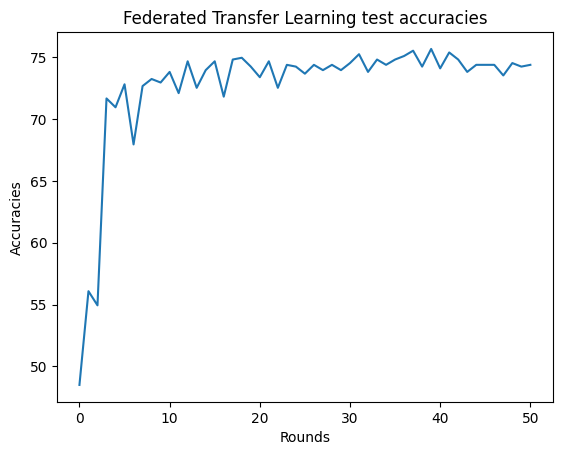

In [25]:
f = []
for i in ftl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Transfer Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')

In [26]:
max(ftl_acc)

tensor(75.6795, device='cuda:0')

In [27]:
torch.save(net_FTL.state_dict(), 'FTL1c.pth')